# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled_small_ip_layer = bilinear_upsample(small_ip_layer)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_small_ip_layer, large_ip_layer])
    
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm( output_layer, filters, strides=1)
    output_layer = separable_conv2d_batchnorm( output_layer, filters, strides=1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    print("Inputs  shape:",inputs.shape, "  \tImage Size in Pixels")
    
    layer01 = encoder_block(inputs , filters=32 , strides=2)
    print("layer01 shape:",layer01.shape, "  \tEncoder Block 1")
    
    layer02 = encoder_block(layer01, filters=64 , strides=2)
    print("layer02 shape:",layer02.shape, "  \tEncoder Block 2")
    
    layer03 = encoder_block(layer02, filters=128, strides=2)
    print("layer03 shape:",layer03.shape, "\tEncoder Block 3")

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer04 = conv2d_batchnorm(layer03, filters=256, kernel_size=1, strides=1)
    print("layer04 shape:",layer04.shape, "\t1x1 Conv Layer")
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer05 = decoder_block(layer04, layer02, filters=128 )
    print("layer05 shape:",layer05.shape, "\tDecoder Block 1")
    
    layer06 = decoder_block(layer05, layer01, filters=64  )
    print("layer06 shape:",layer06.shape, "  \tDecoder Block 2")
    
    layer07 = decoder_block(layer06, inputs , filters=32  )
    print("layer07 shape:",layer07.shape, "\tDecoder Block 3")
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer07)
    print("Outputs shape:",outputs.shape, "\tOutput Size in Pixel")
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Inputs  shape: (?, 160, 160, 3)   	Image Size in Pixels
layer01 shape: (?, 80, 80, 32)   	Encoder Block 1
layer02 shape: (?, 40, 40, 64)   	Encoder Block 2
layer03 shape: (?, 20, 20, 128) 	Encoder Block 3
layer04 shape: (?, 20, 20, 256) 	1x1 Conv Layer
layer05 shape: (?, 40, 40, 128) 	Decoder Block 1
layer06 shape: (?, 80, 80, 64)   	Decoder Block 2
layer07 shape: (?, 160, 160, 32) 	Decoder Block 3
Outputs shape: (?, 160, 160, 3) 	Output Size in Pixel


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

### RUN ONE

In [8]:
learning_rate = 0.01
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1
validation_steps = int(1184/batch_size)-1
workers = 2

Epoch 1/40
127/128 [============================>.] - ETA: 0s - loss: 0.1614

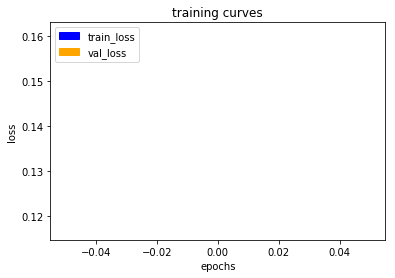

128/128 [==============================] - 78s - loss: 0.1609 - val_loss: 0.1169
Epoch 2/40
127/128 [============================>.] - ETA: 0s - loss: 0.0450

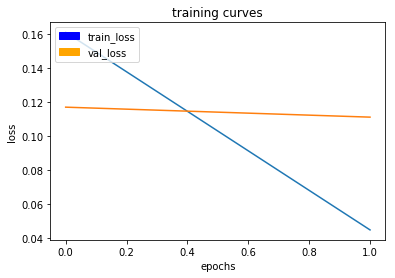

128/128 [==============================] - 76s - loss: 0.0448 - val_loss: 0.1110
Epoch 3/40
127/128 [============================>.] - ETA: 0s - loss: 0.0418

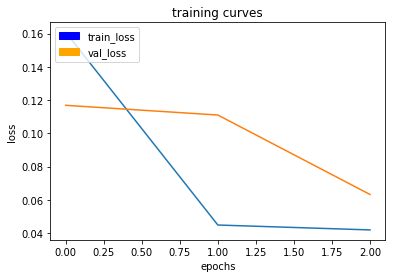

128/128 [==============================] - 76s - loss: 0.0419 - val_loss: 0.0632
Epoch 4/40
127/128 [============================>.] - ETA: 0s - loss: 0.0379

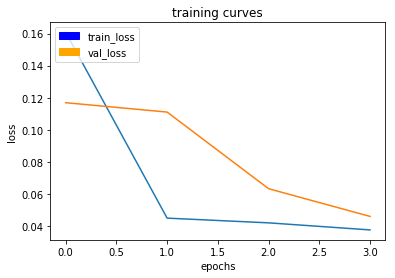

128/128 [==============================] - 76s - loss: 0.0378 - val_loss: 0.0459
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.0341

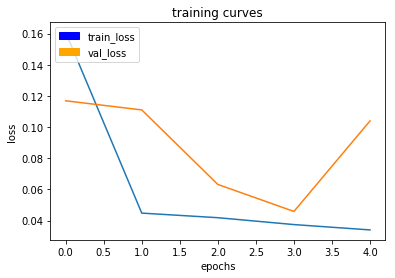

128/128 [==============================] - 76s - loss: 0.0340 - val_loss: 0.1040
Epoch 6/40
127/128 [============================>.] - ETA: 0s - loss: 0.0328

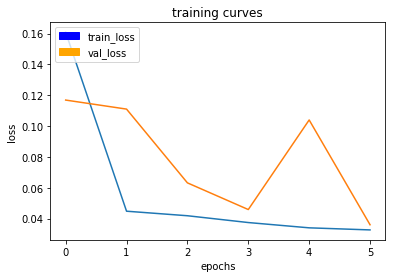

128/128 [==============================] - 75s - loss: 0.0327 - val_loss: 0.0360
Epoch 7/40
127/128 [============================>.] - ETA: 0s - loss: 0.0302

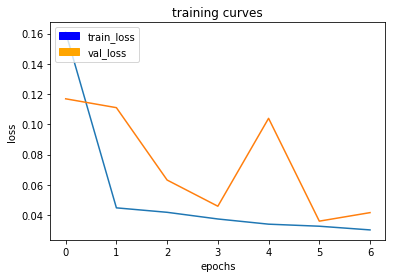

128/128 [==============================] - 76s - loss: 0.0302 - val_loss: 0.0416
Epoch 8/40
127/128 [============================>.] - ETA: 0s - loss: 0.0272

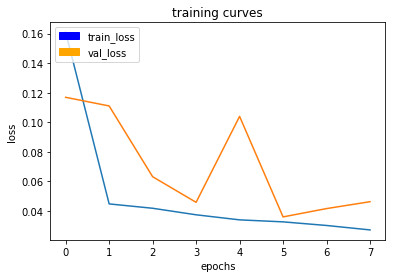

128/128 [==============================] - 76s - loss: 0.0272 - val_loss: 0.0463
Epoch 9/40
127/128 [============================>.] - ETA: 0s - loss: 0.0258

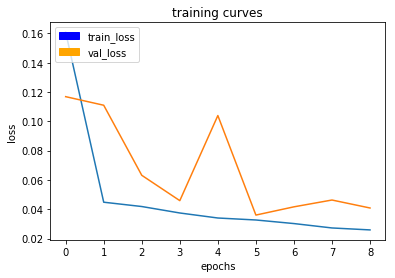

128/128 [==============================] - 76s - loss: 0.0258 - val_loss: 0.0408
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.0269

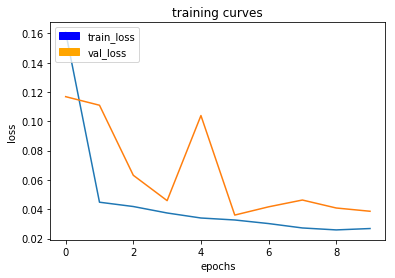

128/128 [==============================] - 75s - loss: 0.0268 - val_loss: 0.0386
Epoch 11/40
127/128 [============================>.] - ETA: 0s - loss: 0.0229

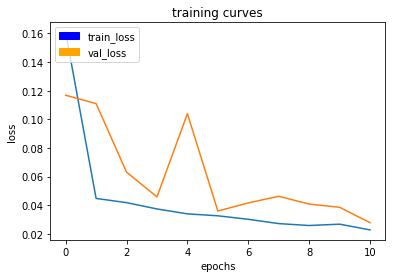

128/128 [==============================] - 76s - loss: 0.0228 - val_loss: 0.0278
Epoch 12/40
127/128 [============================>.] - ETA: 0s - loss: 0.0242

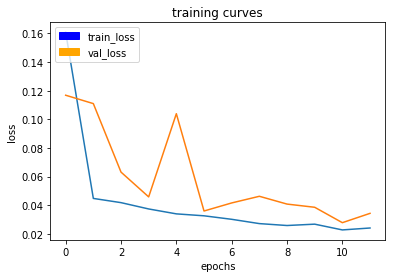

128/128 [==============================] - 76s - loss: 0.0241 - val_loss: 0.0344
Epoch 13/40
127/128 [============================>.] - ETA: 0s - loss: 0.0256

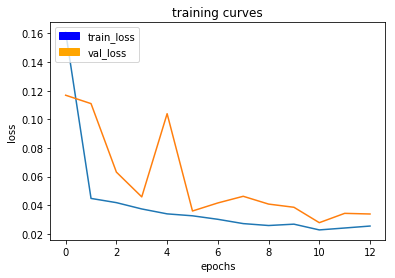

128/128 [==============================] - 76s - loss: 0.0256 - val_loss: 0.0339
Epoch 14/40
127/128 [============================>.] - ETA: 0s - loss: 0.0203

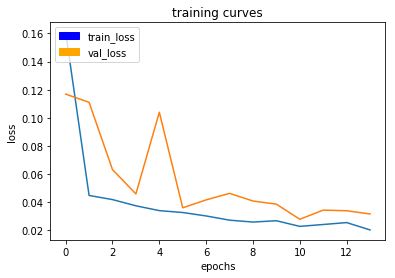

128/128 [==============================] - 76s - loss: 0.0203 - val_loss: 0.0316
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.0238

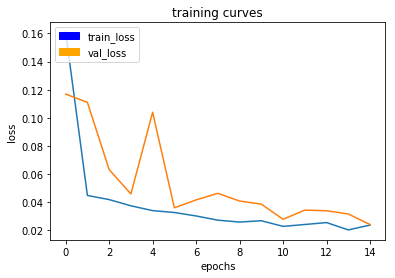

128/128 [==============================] - 76s - loss: 0.0238 - val_loss: 0.0241
Epoch 16/40
127/128 [============================>.] - ETA: 0s - loss: 0.0209

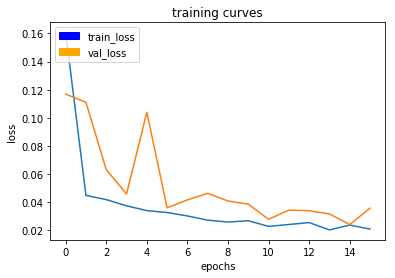

128/128 [==============================] - 76s - loss: 0.0209 - val_loss: 0.0357
Epoch 17/40
127/128 [============================>.] - ETA: 0s - loss: 0.0194

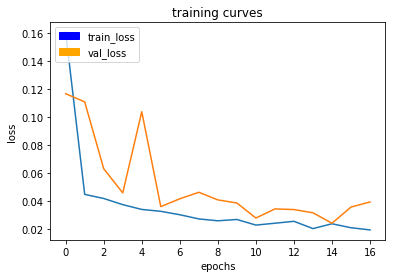

128/128 [==============================] - 76s - loss: 0.0194 - val_loss: 0.0394
Epoch 18/40
127/128 [============================>.] - ETA: 0s - loss: 0.0202

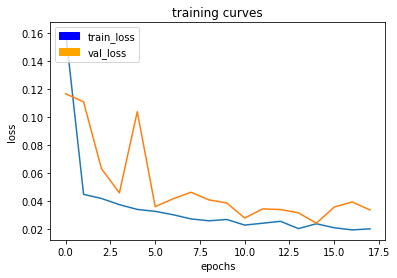

128/128 [==============================] - 76s - loss: 0.0202 - val_loss: 0.0336
Epoch 19/40
127/128 [============================>.] - ETA: 0s - loss: 0.0207

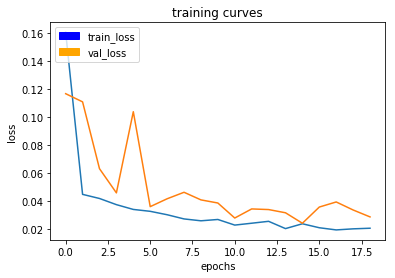

128/128 [==============================] - 76s - loss: 0.0207 - val_loss: 0.0286
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0198

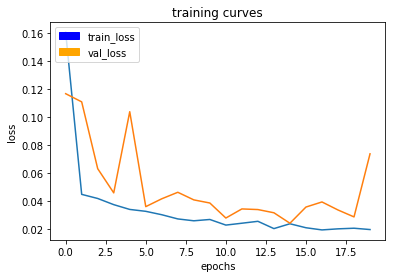

128/128 [==============================] - 76s - loss: 0.0199 - val_loss: 0.0738
Epoch 21/40
127/128 [============================>.] - ETA: 0s - loss: 0.0175

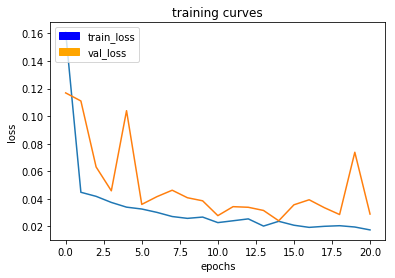

128/128 [==============================] - 75s - loss: 0.0176 - val_loss: 0.0290
Epoch 22/40
127/128 [============================>.] - ETA: 0s - loss: 0.0196

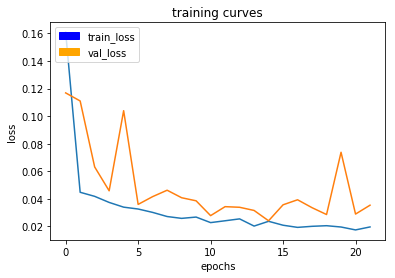

128/128 [==============================] - 76s - loss: 0.0196 - val_loss: 0.0354
Epoch 23/40
127/128 [============================>.] - ETA: 0s - loss: 0.0202

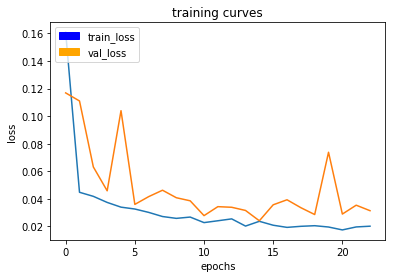

128/128 [==============================] - 76s - loss: 0.0202 - val_loss: 0.0314
Epoch 24/40
127/128 [============================>.] - ETA: 0s - loss: 0.0169

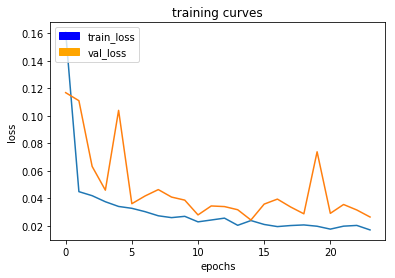

128/128 [==============================] - 76s - loss: 0.0169 - val_loss: 0.0263
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0168

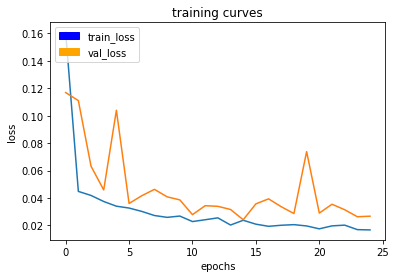

128/128 [==============================] - 76s - loss: 0.0168 - val_loss: 0.0267
Epoch 26/40
127/128 [============================>.] - ETA: 0s - loss: 0.0172

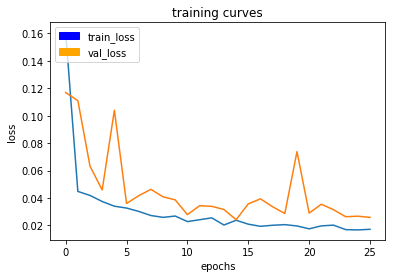

128/128 [==============================] - 76s - loss: 0.0172 - val_loss: 0.0258
Epoch 27/40
127/128 [============================>.] - ETA: 0s - loss: 0.0154

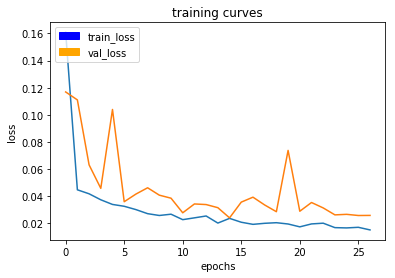

128/128 [==============================] - 75s - loss: 0.0154 - val_loss: 0.0259
Epoch 28/40
127/128 [============================>.] - ETA: 0s - loss: 0.0194

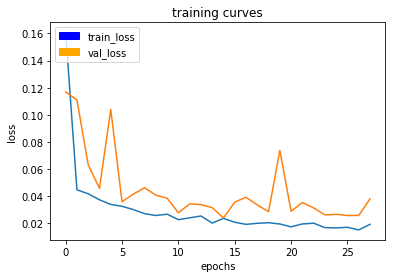

128/128 [==============================] - 76s - loss: 0.0194 - val_loss: 0.0382
Epoch 29/40
127/128 [============================>.] - ETA: 0s - loss: 0.0174

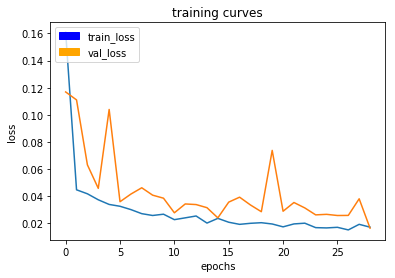

128/128 [==============================] - 76s - loss: 0.0174 - val_loss: 0.0165
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0183

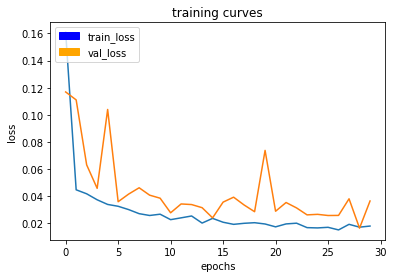

128/128 [==============================] - 76s - loss: 0.0182 - val_loss: 0.0365
Epoch 31/40
127/128 [============================>.] - ETA: 0s - loss: 0.0153

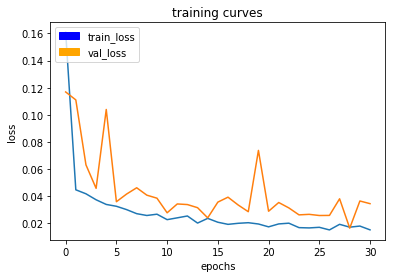

128/128 [==============================] - 76s - loss: 0.0153 - val_loss: 0.0346
Epoch 32/40
127/128 [============================>.] - ETA: 0s - loss: 0.0164

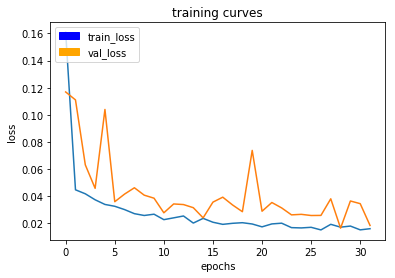

128/128 [==============================] - 76s - loss: 0.0164 - val_loss: 0.0185
Epoch 33/40
127/128 [============================>.] - ETA: 0s - loss: 0.0185

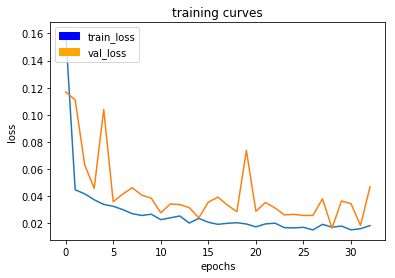

128/128 [==============================] - 75s - loss: 0.0185 - val_loss: 0.0470
Epoch 34/40
127/128 [============================>.] - ETA: 0s - loss: 0.0152

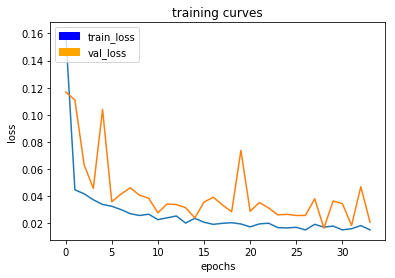

128/128 [==============================] - 76s - loss: 0.0152 - val_loss: 0.0209
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0135

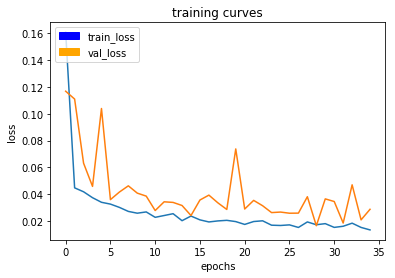

128/128 [==============================] - 76s - loss: 0.0134 - val_loss: 0.0288
Epoch 36/40
127/128 [============================>.] - ETA: 0s - loss: 0.0137

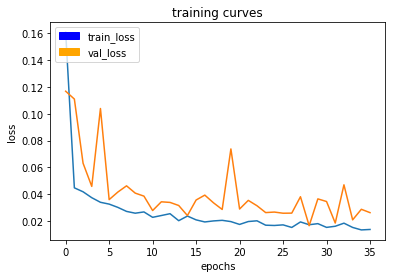

128/128 [==============================] - 76s - loss: 0.0137 - val_loss: 0.0263
Epoch 37/40
127/128 [============================>.] - ETA: 0s - loss: 0.0148

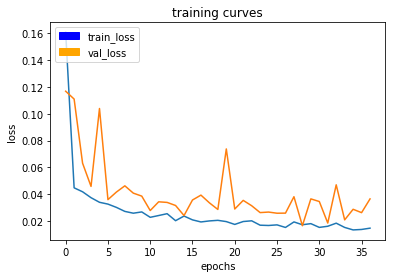

128/128 [==============================] - 75s - loss: 0.0148 - val_loss: 0.0365
Epoch 38/40
127/128 [============================>.] - ETA: 0s - loss: 0.0178

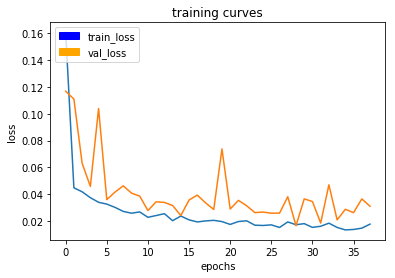

128/128 [==============================] - 76s - loss: 0.0178 - val_loss: 0.0310
Epoch 39/40
127/128 [============================>.] - ETA: 0s - loss: 0.0160

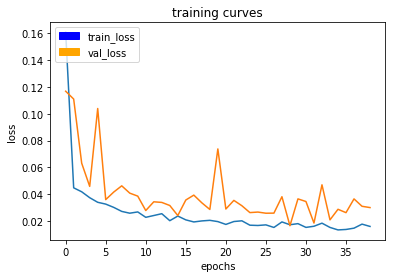

128/128 [==============================] - 76s - loss: 0.0160 - val_loss: 0.0301
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0161

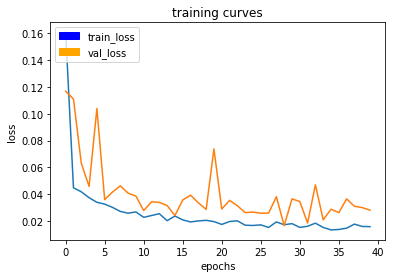

128/128 [==============================] - 75s - loss: 0.0160 - val_loss: 0.0281


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights_1.h5'
model_tools.save_network(model, weight_file_name)

### RUN TWO

Inputs  shape: (?, 160, 160, 3)   	Image Size in Pixels
layer01 shape: (?, 80, 80, 32)   	Encoder Block 1
layer02 shape: (?, 40, 40, 64)   	Encoder Block 2
layer03 shape: (?, 20, 20, 128) 	Encoder Block 3
layer04 shape: (?, 20, 20, 256) 	1x1 Conv Layer
layer05 shape: (?, 40, 40, 128) 	Decoder Block 1
layer06 shape: (?, 80, 80, 64)   	Decoder Block 2
layer07 shape: (?, 160, 160, 32) 	Decoder Block 3
Outputs shape: (?, 160, 160, 3) 	Output Size in Pixel
Epoch 1/40
127/128 [============================>.] - ETA: 0s - loss: 0.7068

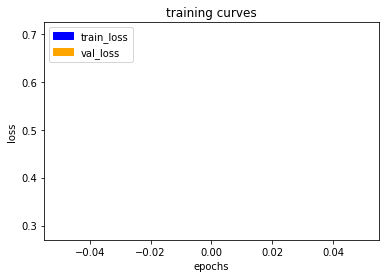

128/128 [==============================] - 77s - loss: 0.7034 - val_loss: 0.2908
Epoch 2/40
127/128 [============================>.] - ETA: 0s - loss: 0.1467

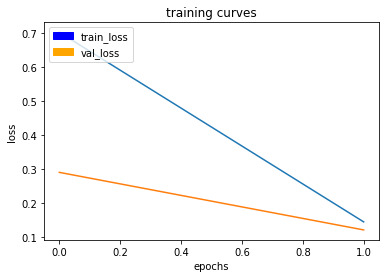

128/128 [==============================] - 75s - loss: 0.1461 - val_loss: 0.1214
Epoch 3/40
127/128 [============================>.] - ETA: 0s - loss: 0.0665

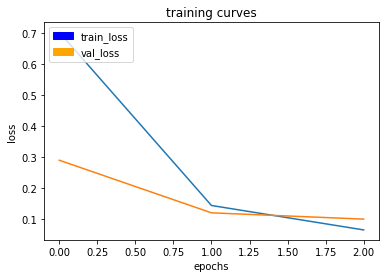

128/128 [==============================] - 76s - loss: 0.0665 - val_loss: 0.1011
Epoch 4/40
127/128 [============================>.] - ETA: 0s - loss: 0.0500

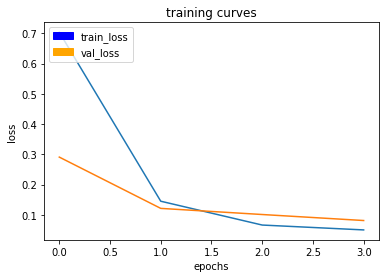

128/128 [==============================] - 75s - loss: 0.0503 - val_loss: 0.0813
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.0429

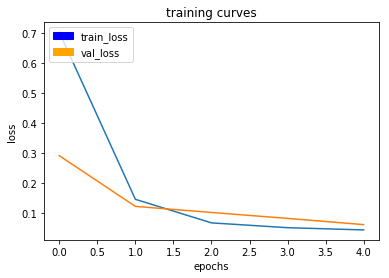

128/128 [==============================] - 75s - loss: 0.0428 - val_loss: 0.0605
Epoch 6/40
127/128 [============================>.] - ETA: 0s - loss: 0.0435

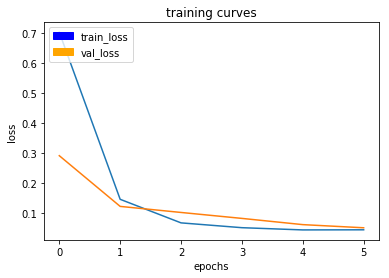

128/128 [==============================] - 75s - loss: 0.0435 - val_loss: 0.0500
Epoch 7/40
127/128 [============================>.] - ETA: 0s - loss: 0.0362

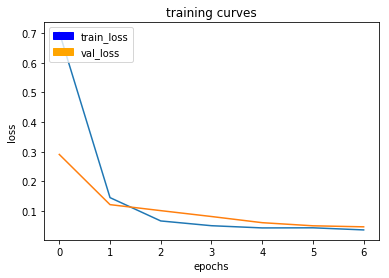

128/128 [==============================] - 75s - loss: 0.0362 - val_loss: 0.0465
Epoch 8/40
127/128 [============================>.] - ETA: 0s - loss: 0.0402

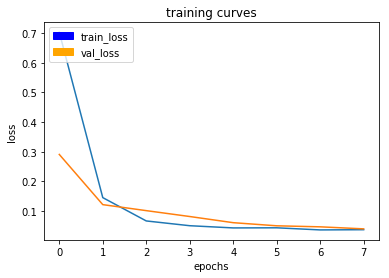

128/128 [==============================] - 75s - loss: 0.0401 - val_loss: 0.0396
Epoch 9/40
127/128 [============================>.] - ETA: 0s - loss: 0.0308

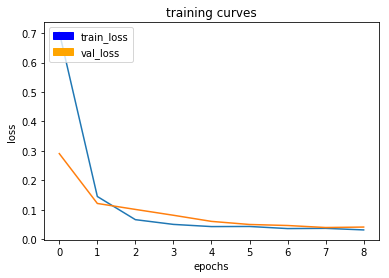

128/128 [==============================] - 75s - loss: 0.0315 - val_loss: 0.0412
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.0308

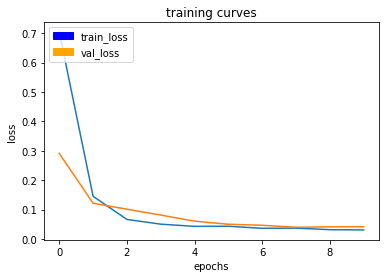

128/128 [==============================] - 76s - loss: 0.0307 - val_loss: 0.0417
Epoch 11/40
127/128 [============================>.] - ETA: 0s - loss: 0.0297

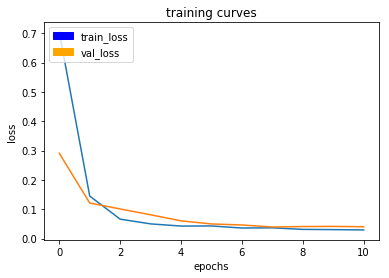

128/128 [==============================] - 75s - loss: 0.0297 - val_loss: 0.0404
Epoch 12/40
127/128 [============================>.] - ETA: 0s - loss: 0.0272

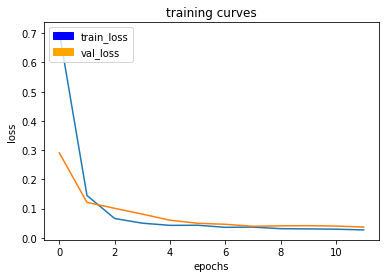

128/128 [==============================] - 75s - loss: 0.0272 - val_loss: 0.0371
Epoch 13/40
127/128 [============================>.] - ETA: 0s - loss: 0.0263

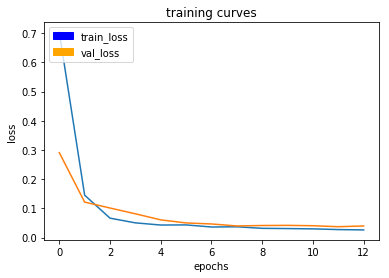

128/128 [==============================] - 76s - loss: 0.0263 - val_loss: 0.0396
Epoch 14/40
127/128 [============================>.] - ETA: 0s - loss: 0.0253

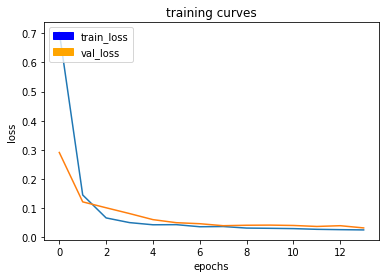

128/128 [==============================] - 75s - loss: 0.0252 - val_loss: 0.0320
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.0251

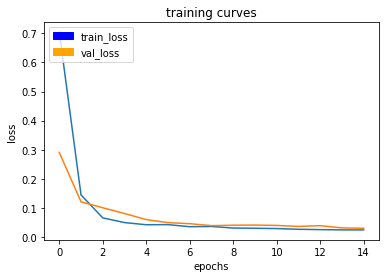

128/128 [==============================] - 75s - loss: 0.0251 - val_loss: 0.0307
Epoch 16/40
127/128 [============================>.] - ETA: 0s - loss: 0.0229

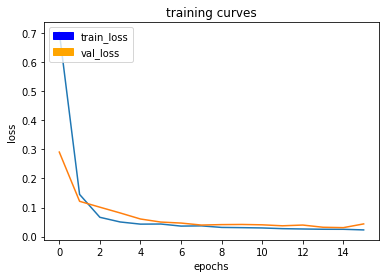

128/128 [==============================] - 75s - loss: 0.0229 - val_loss: 0.0436
Epoch 17/40
127/128 [============================>.] - ETA: 0s - loss: 0.0225

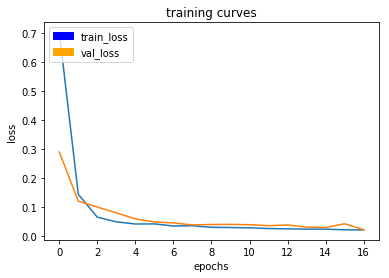

128/128 [==============================] - 75s - loss: 0.0225 - val_loss: 0.0231
Epoch 18/40
127/128 [============================>.] - ETA: 0s - loss: 0.0241

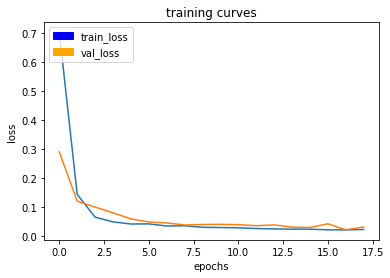

128/128 [==============================] - 75s - loss: 0.0241 - val_loss: 0.0323
Epoch 19/40
127/128 [============================>.] - ETA: 0s - loss: 0.0212

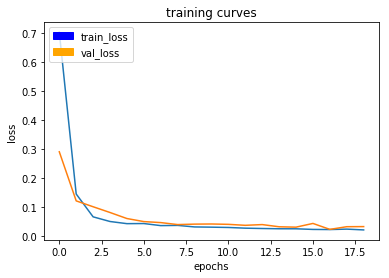

128/128 [==============================] - 75s - loss: 0.0212 - val_loss: 0.0327
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0218

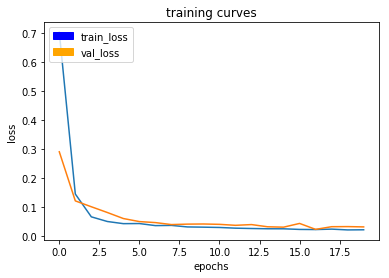

128/128 [==============================] - 75s - loss: 0.0217 - val_loss: 0.0316
Epoch 21/40
127/128 [============================>.] - ETA: 0s - loss: 0.0201

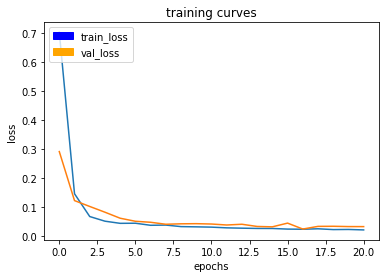

128/128 [==============================] - 75s - loss: 0.0201 - val_loss: 0.0315
Epoch 22/40
127/128 [============================>.] - ETA: 0s - loss: 0.0218

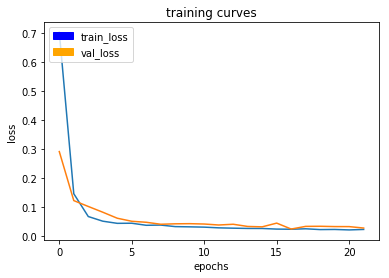

128/128 [==============================] - 75s - loss: 0.0218 - val_loss: 0.0265
Epoch 23/40
127/128 [============================>.] - ETA: 0s - loss: 0.0215

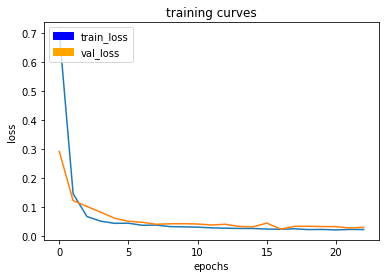

128/128 [==============================] - 75s - loss: 0.0214 - val_loss: 0.0292
Epoch 24/40
127/128 [============================>.] - ETA: 0s - loss: 0.0173

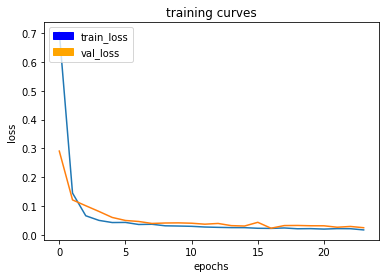

128/128 [==============================] - 75s - loss: 0.0173 - val_loss: 0.0248
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0196

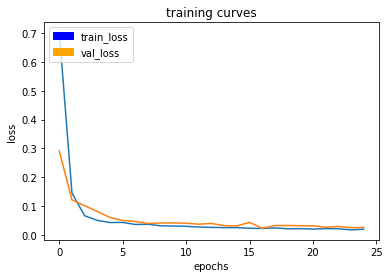

128/128 [==============================] - 75s - loss: 0.0197 - val_loss: 0.0260
Epoch 26/40
127/128 [============================>.] - ETA: 0s - loss: 0.0174

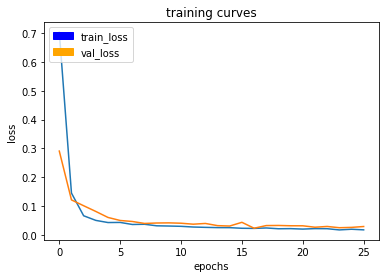

128/128 [==============================] - 76s - loss: 0.0175 - val_loss: 0.0290
Epoch 27/40
127/128 [============================>.] - ETA: 0s - loss: 0.0162

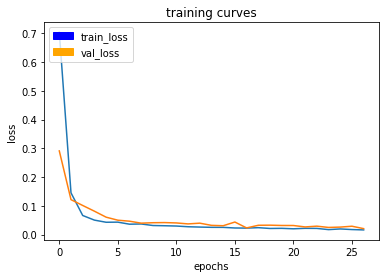

128/128 [==============================] - 75s - loss: 0.0162 - val_loss: 0.0207
Epoch 28/40
127/128 [============================>.] - ETA: 0s - loss: 0.0181

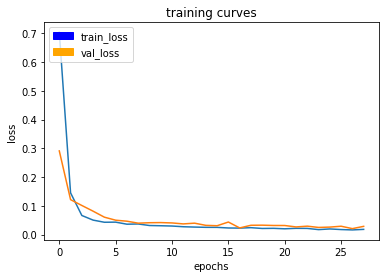

128/128 [==============================] - 75s - loss: 0.0181 - val_loss: 0.0286
Epoch 29/40
127/128 [============================>.] - ETA: 0s - loss: 0.0166

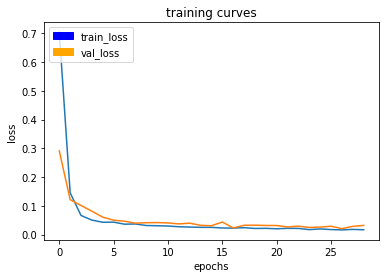

128/128 [==============================] - 75s - loss: 0.0166 - val_loss: 0.0319
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0185

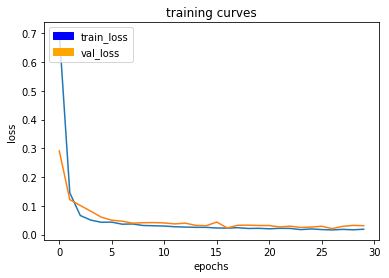

128/128 [==============================] - 75s - loss: 0.0185 - val_loss: 0.0309
Epoch 31/40
127/128 [============================>.] - ETA: 0s - loss: 0.0175

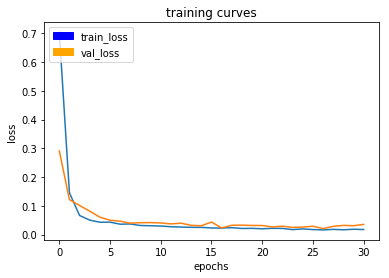

128/128 [==============================] - 75s - loss: 0.0176 - val_loss: 0.0352
Epoch 32/40
127/128 [============================>.] - ETA: 0s - loss: 0.0176

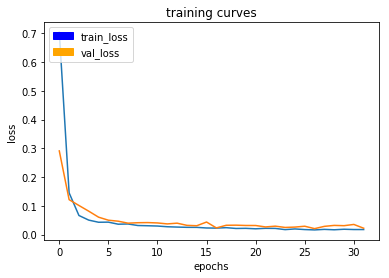

128/128 [==============================] - 75s - loss: 0.0176 - val_loss: 0.0221
Epoch 33/40
127/128 [============================>.] - ETA: 0s - loss: 0.0160

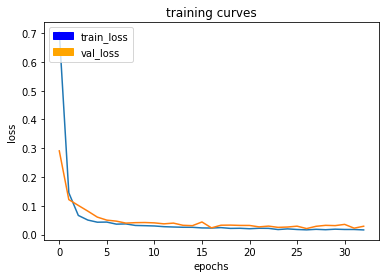

128/128 [==============================] - 75s - loss: 0.0159 - val_loss: 0.0287
Epoch 34/40
127/128 [============================>.] - ETA: 0s - loss: 0.0160

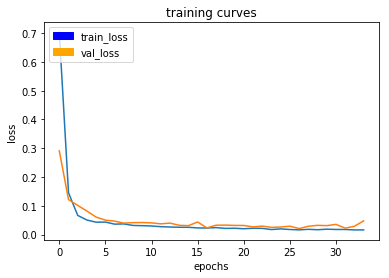

128/128 [==============================] - 75s - loss: 0.0160 - val_loss: 0.0474
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0166

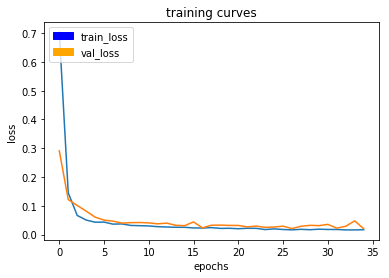

128/128 [==============================] - 75s - loss: 0.0165 - val_loss: 0.0202
Epoch 36/40
127/128 [============================>.] - ETA: 0s - loss: 0.0144

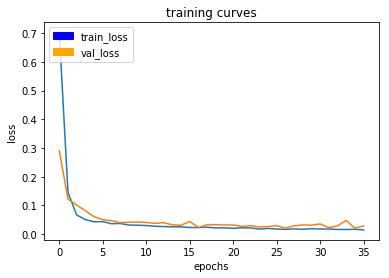

128/128 [==============================] - 75s - loss: 0.0144 - val_loss: 0.0284
Epoch 37/40
127/128 [============================>.] - ETA: 0s - loss: 0.0151

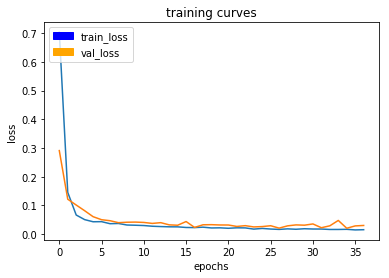

128/128 [==============================] - 75s - loss: 0.0151 - val_loss: 0.0299
Epoch 38/40
127/128 [============================>.] - ETA: 0s - loss: 0.0151

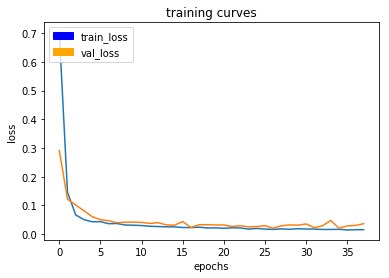

128/128 [==============================] - 76s - loss: 0.0151 - val_loss: 0.0361
Epoch 39/40
127/128 [============================>.] - ETA: 0s - loss: 0.0152

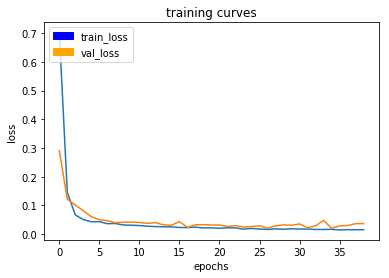

128/128 [==============================] - 75s - loss: 0.0152 - val_loss: 0.0365
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0153

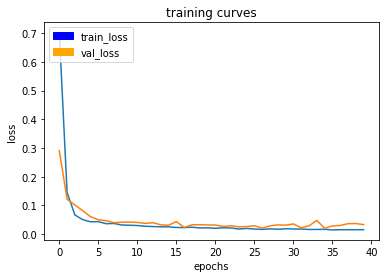

128/128 [==============================] - 75s - loss: 0.0153 - val_loss: 0.0330


In [31]:
# RUN TWO

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.001
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1
validation_steps = int(1184/batch_size)-1
workers = 2 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights_2.h5'
model_tools.save_network(model, weight_file_name)

### RUN THREE

Inputs  shape: (?, 160, 160, 3)   	Image Size in Pixels
layer01 shape: (?, 80, 80, 32)   	Encoder Block 1
layer02 shape: (?, 40, 40, 64)   	Encoder Block 2
layer03 shape: (?, 20, 20, 128) 	Encoder Block 3
layer04 shape: (?, 20, 20, 256) 	1x1 Conv Layer
layer05 shape: (?, 40, 40, 128) 	Decoder Block 1
layer06 shape: (?, 80, 80, 64)   	Decoder Block 2
layer07 shape: (?, 160, 160, 32) 	Decoder Block 3
Outputs shape: (?, 160, 160, 3) 	Output Size in Pixel
Epoch 1/40
127/128 [============================>.] - ETA: 0s - loss: 1.1537

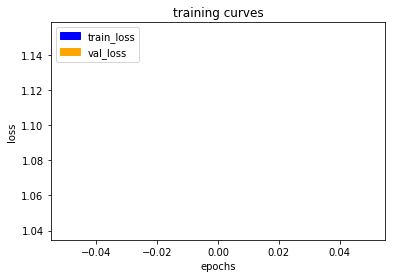

128/128 [==============================] - 77s - loss: 1.1529 - val_loss: 1.0404
Epoch 2/40
127/128 [============================>.] - ETA: 0s - loss: 1.0006

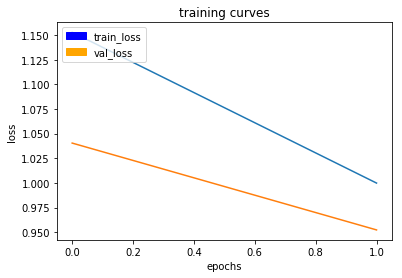

128/128 [==============================] - 76s - loss: 1.0002 - val_loss: 0.9523
Epoch 3/40
127/128 [============================>.] - ETA: 0s - loss: 0.9094

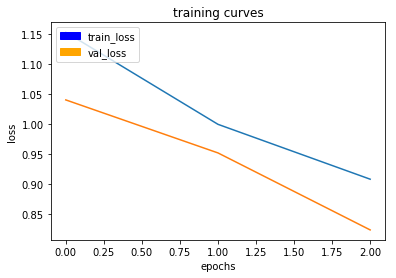

128/128 [==============================] - 75s - loss: 0.9089 - val_loss: 0.8243
Epoch 4/40
127/128 [============================>.] - ETA: 0s - loss: 0.7918

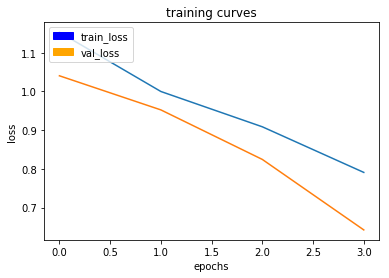

128/128 [==============================] - 75s - loss: 0.7912 - val_loss: 0.6422
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.6529

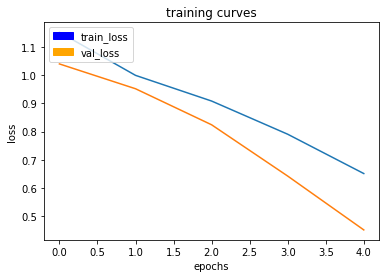

128/128 [==============================] - 75s - loss: 0.6525 - val_loss: 0.4509
Epoch 6/40
127/128 [============================>.] - ETA: 0s - loss: 0.5365

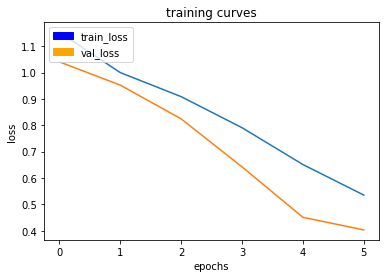

128/128 [==============================] - 75s - loss: 0.5361 - val_loss: 0.4031
Epoch 7/40
127/128 [============================>.] - ETA: 0s - loss: 0.4382

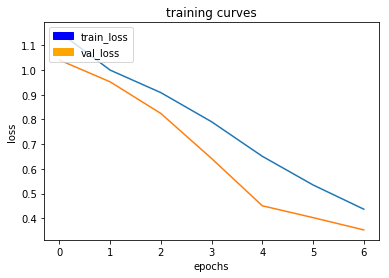

128/128 [==============================] - 76s - loss: 0.4378 - val_loss: 0.3533
Epoch 8/40
127/128 [============================>.] - ETA: 0s - loss: 0.3632

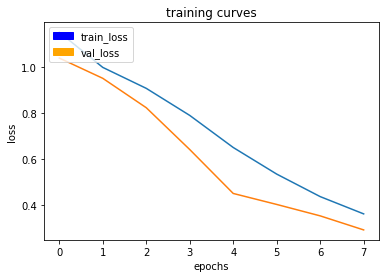

128/128 [==============================] - 75s - loss: 0.3629 - val_loss: 0.2921
Epoch 9/40
127/128 [============================>.] - ETA: 0s - loss: 0.3005

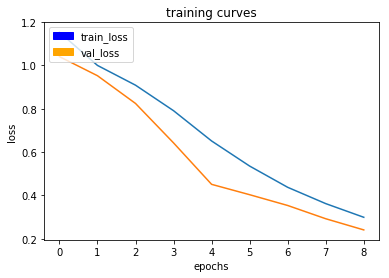

128/128 [==============================] - 75s - loss: 0.3003 - val_loss: 0.2406
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.2492

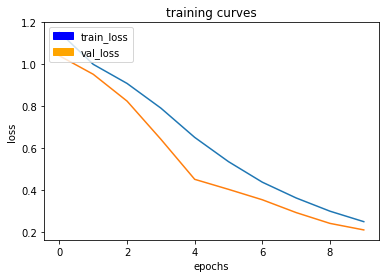

128/128 [==============================] - 75s - loss: 0.2491 - val_loss: 0.2094
Epoch 11/40
127/128 [============================>.] - ETA: 0s - loss: 0.2166

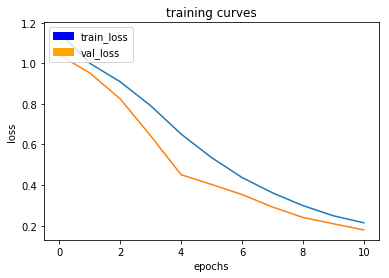

128/128 [==============================] - 75s - loss: 0.2163 - val_loss: 0.1791
Epoch 12/40
127/128 [============================>.] - ETA: 0s - loss: 0.1798

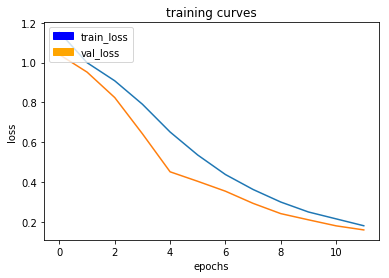

128/128 [==============================] - 76s - loss: 0.1798 - val_loss: 0.1586
Epoch 13/40
127/128 [============================>.] - ETA: 0s - loss: 0.1547

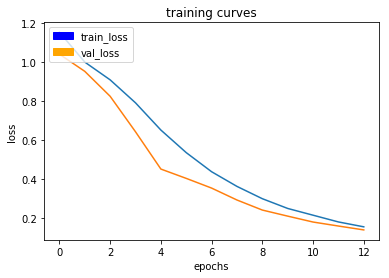

128/128 [==============================] - 75s - loss: 0.1546 - val_loss: 0.1387
Epoch 14/40
127/128 [============================>.] - ETA: 0s - loss: 0.1348

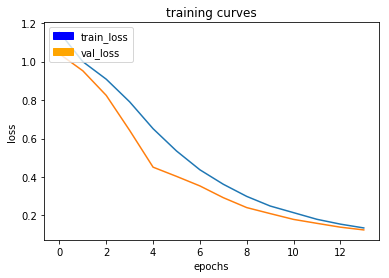

128/128 [==============================] - 75s - loss: 0.1347 - val_loss: 0.1244
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.1188

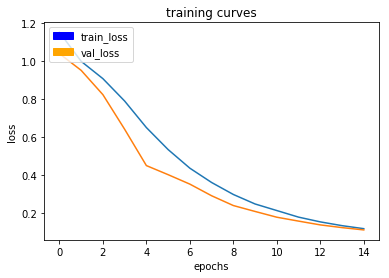

128/128 [==============================] - 76s - loss: 0.1187 - val_loss: 0.1123
Epoch 16/40
127/128 [============================>.] - ETA: 0s - loss: 0.1067

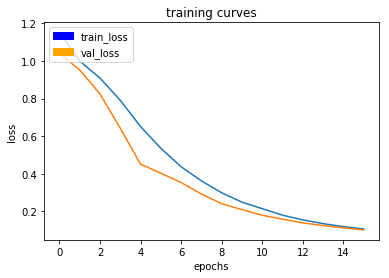

128/128 [==============================] - 75s - loss: 0.1066 - val_loss: 0.1013
Epoch 17/40
127/128 [============================>.] - ETA: 0s - loss: 0.1004

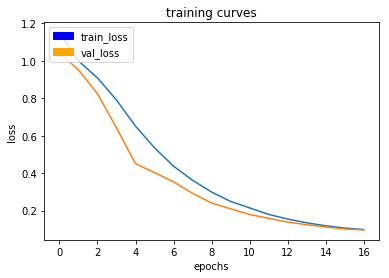

128/128 [==============================] - 75s - loss: 0.1003 - val_loss: 0.0966
Epoch 18/40
127/128 [============================>.] - ETA: 0s - loss: 0.0924

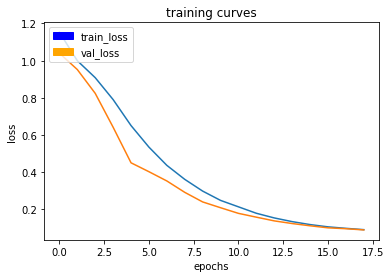

128/128 [==============================] - 76s - loss: 0.0923 - val_loss: 0.0901
Epoch 19/40
127/128 [============================>.] - ETA: 0s - loss: 0.0831

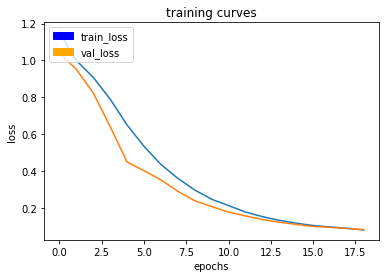

128/128 [==============================] - 76s - loss: 0.0831 - val_loss: 0.0839
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0744

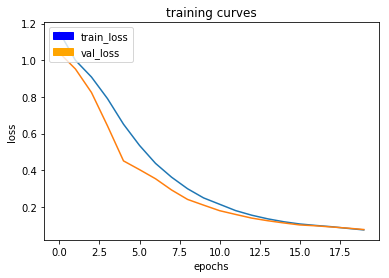

128/128 [==============================] - 75s - loss: 0.0744 - val_loss: 0.0762
Epoch 21/40
127/128 [============================>.] - ETA: 0s - loss: 0.0698

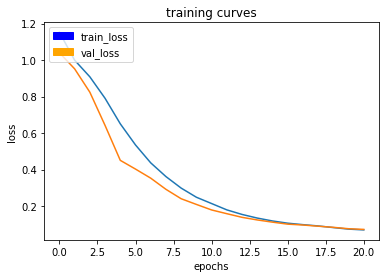

128/128 [==============================] - 75s - loss: 0.0697 - val_loss: 0.0725
Epoch 22/40
127/128 [============================>.] - ETA: 0s - loss: 0.0653

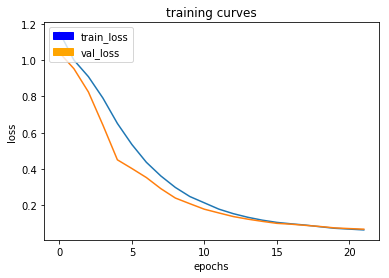

128/128 [==============================] - 75s - loss: 0.0653 - val_loss: 0.0693
Epoch 23/40
127/128 [============================>.] - ETA: 0s - loss: 0.0624

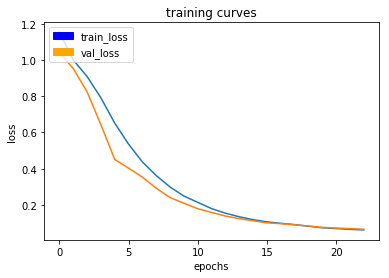

128/128 [==============================] - 76s - loss: 0.0624 - val_loss: 0.0659
Epoch 24/40
127/128 [============================>.] - ETA: 0s - loss: 0.0578

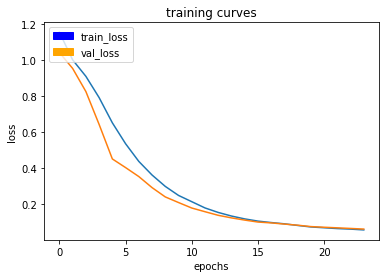

128/128 [==============================] - 76s - loss: 0.0578 - val_loss: 0.0624
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0542

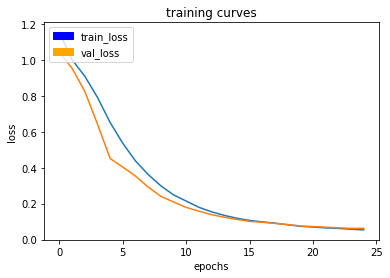

128/128 [==============================] - 76s - loss: 0.0542 - val_loss: 0.0627
Epoch 26/40
127/128 [============================>.] - ETA: 0s - loss: 0.0515

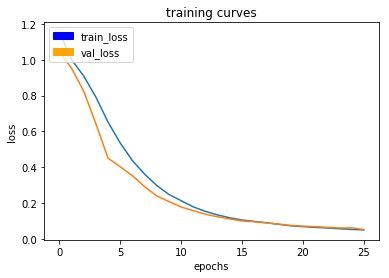

128/128 [==============================] - 75s - loss: 0.0514 - val_loss: 0.0539
Epoch 27/40
127/128 [============================>.] - ETA: 0s - loss: 0.0508

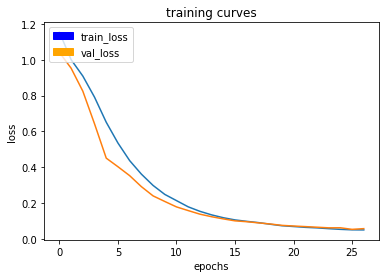

128/128 [==============================] - 75s - loss: 0.0508 - val_loss: 0.0579
Epoch 28/40
127/128 [============================>.] - ETA: 0s - loss: 0.0487

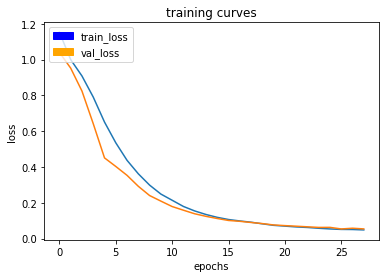

128/128 [==============================] - 75s - loss: 0.0487 - val_loss: 0.0542
Epoch 29/40
127/128 [============================>.] - ETA: 0s - loss: 0.0457

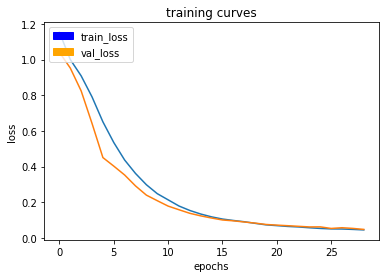

128/128 [==============================] - 76s - loss: 0.0457 - val_loss: 0.0485
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0443

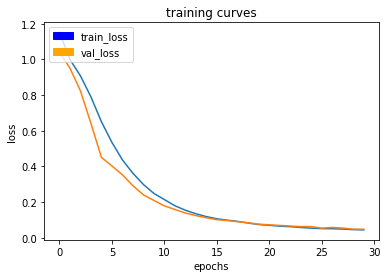

128/128 [==============================] - 76s - loss: 0.0443 - val_loss: 0.0480
Epoch 31/40
127/128 [============================>.] - ETA: 0s - loss: 0.0415

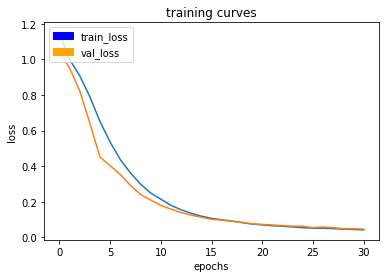

128/128 [==============================] - 76s - loss: 0.0415 - val_loss: 0.0464
Epoch 32/40
127/128 [============================>.] - ETA: 0s - loss: 0.0422

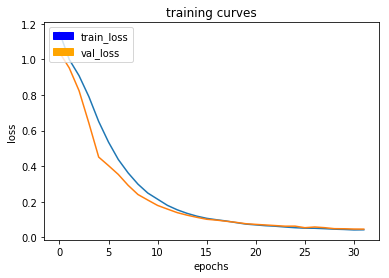

128/128 [==============================] - 76s - loss: 0.0422 - val_loss: 0.0460
Epoch 33/40
127/128 [============================>.] - ETA: 0s - loss: 0.0400

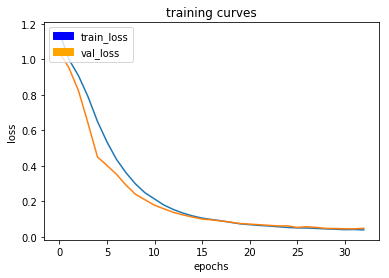

128/128 [==============================] - 76s - loss: 0.0400 - val_loss: 0.0492
Epoch 34/40
127/128 [============================>.] - ETA: 0s - loss: 0.0403

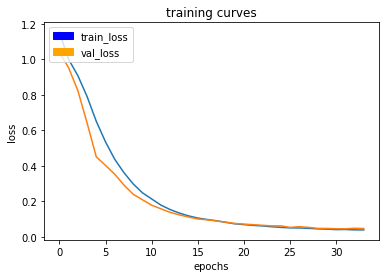

128/128 [==============================] - 75s - loss: 0.0402 - val_loss: 0.0476
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0389

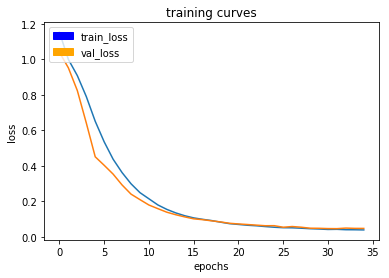

128/128 [==============================] - 75s - loss: 0.0389 - val_loss: 0.0473
Epoch 36/40
127/128 [============================>.] - ETA: 0s - loss: 0.0373

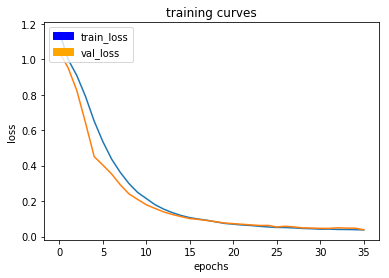

128/128 [==============================] - 76s - loss: 0.0373 - val_loss: 0.0381
Epoch 37/40
127/128 [============================>.] - ETA: 0s - loss: 0.0355

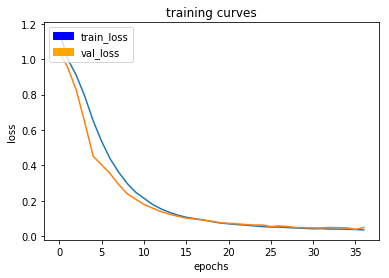

128/128 [==============================] - 76s - loss: 0.0354 - val_loss: 0.0485
Epoch 38/40
127/128 [============================>.] - ETA: 0s - loss: 0.0362

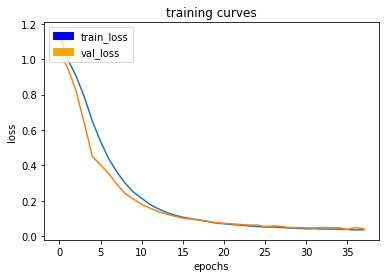

128/128 [==============================] - 76s - loss: 0.0362 - val_loss: 0.0408
Epoch 39/40
127/128 [============================>.] - ETA: 0s - loss: 0.0339

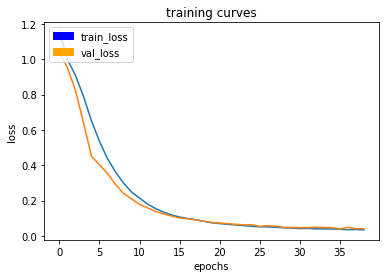

128/128 [==============================] - 76s - loss: 0.0339 - val_loss: 0.0405
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0335

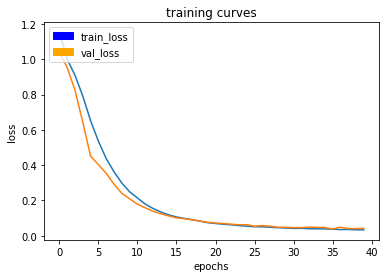

128/128 [==============================] - 76s - loss: 0.0334 - val_loss: 0.0424


In [12]:
# RUN THREE

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.0001
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1
validation_steps = int(1184/batch_size)-1
workers = 2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights_3.h5'
model_tools.save_network(model, weight_file_name)

### RUN FOUR

Inputs  shape: (?, 160, 160, 3)   	Image Size in Pixels
layer01 shape: (?, 80, 80, 32)   	Encoder Block 1
layer02 shape: (?, 40, 40, 64)   	Encoder Block 2
layer03 shape: (?, 20, 20, 128) 	Encoder Block 3
layer04 shape: (?, 20, 20, 256) 	1x1 Conv Layer
layer05 shape: (?, 40, 40, 128) 	Decoder Block 1
layer06 shape: (?, 80, 80, 64)   	Decoder Block 2
layer07 shape: (?, 160, 160, 32) 	Decoder Block 3
Outputs shape: (?, 160, 160, 3) 	Output Size in Pixel
Epoch 1/100
127/128 [============================>.] - ETA: 0s - loss: 0.1585

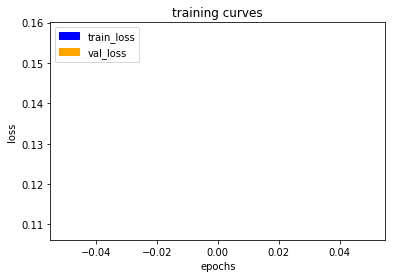

128/128 [==============================] - 78s - loss: 0.1576 - val_loss: 0.1086
Epoch 2/100
127/128 [============================>.] - ETA: 0s - loss: 0.0464

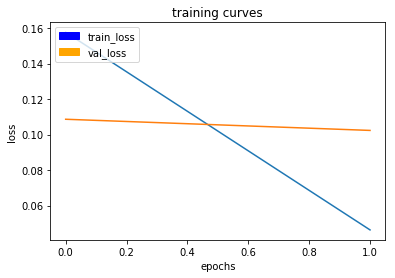

128/128 [==============================] - 76s - loss: 0.0464 - val_loss: 0.1023
Epoch 3/100
127/128 [============================>.] - ETA: 0s - loss: 0.0420

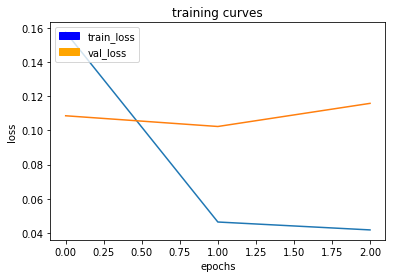

128/128 [==============================] - 76s - loss: 0.0419 - val_loss: 0.1159
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 0.0365

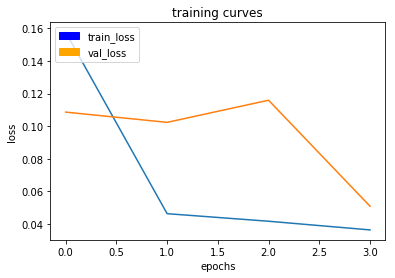

128/128 [==============================] - 76s - loss: 0.0364 - val_loss: 0.0509
Epoch 5/100
127/128 [============================>.] - ETA: 0s - loss: 0.0333

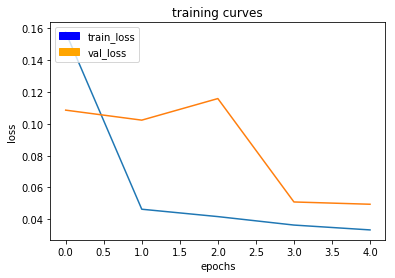

128/128 [==============================] - 76s - loss: 0.0332 - val_loss: 0.0494
Epoch 6/100
127/128 [============================>.] - ETA: 0s - loss: 0.0320

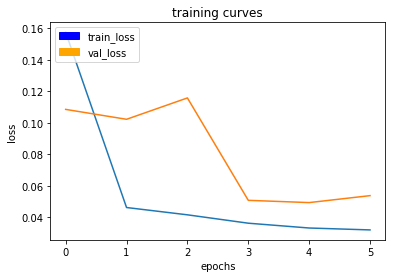

128/128 [==============================] - 76s - loss: 0.0321 - val_loss: 0.0539
Epoch 7/100
127/128 [============================>.] - ETA: 0s - loss: 0.0298

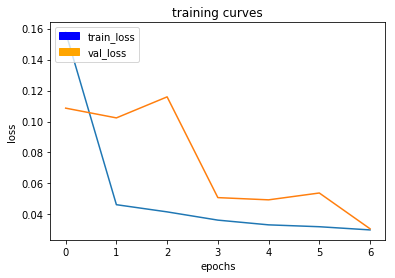

128/128 [==============================] - 76s - loss: 0.0301 - val_loss: 0.0308
Epoch 8/100
127/128 [============================>.] - ETA: 0s - loss: 0.0280

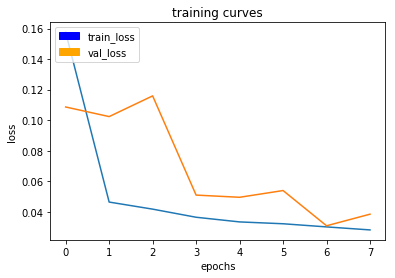

128/128 [==============================] - 76s - loss: 0.0280 - val_loss: 0.0384
Epoch 9/100
127/128 [============================>.] - ETA: 0s - loss: 0.0260

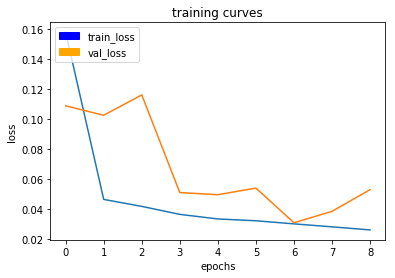

128/128 [==============================] - 76s - loss: 0.0260 - val_loss: 0.0528
Epoch 10/100
127/128 [============================>.] - ETA: 0s - loss: 0.0271

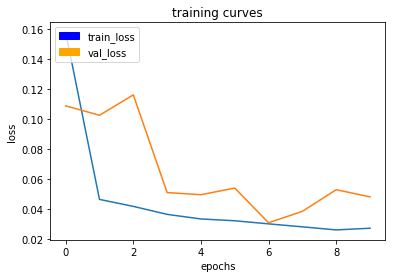

128/128 [==============================] - 76s - loss: 0.0272 - val_loss: 0.0480
Epoch 11/100
127/128 [============================>.] - ETA: 0s - loss: 0.0251

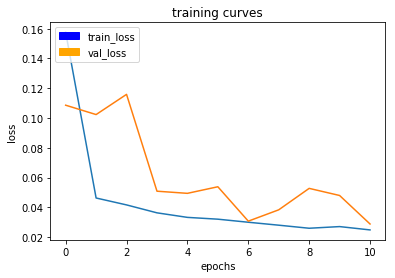

128/128 [==============================] - 75s - loss: 0.0251 - val_loss: 0.0289
Epoch 12/100
127/128 [============================>.] - ETA: 0s - loss: 0.0252

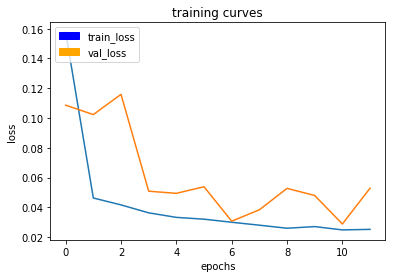

128/128 [==============================] - 76s - loss: 0.0252 - val_loss: 0.0529
Epoch 13/100
127/128 [============================>.] - ETA: 0s - loss: 0.0241

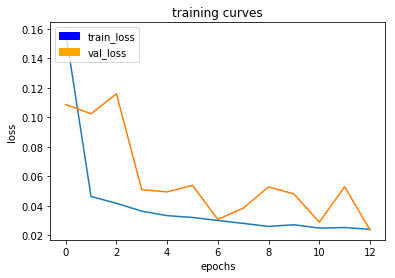

128/128 [==============================] - 76s - loss: 0.0241 - val_loss: 0.0236
Epoch 14/100
127/128 [============================>.] - ETA: 0s - loss: 0.0225

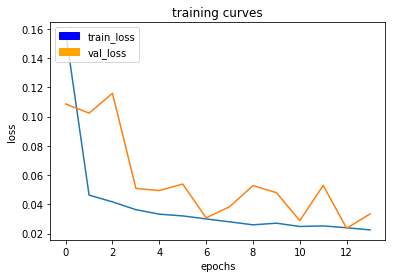

128/128 [==============================] - 76s - loss: 0.0225 - val_loss: 0.0335
Epoch 15/100
127/128 [============================>.] - ETA: 0s - loss: 0.0215

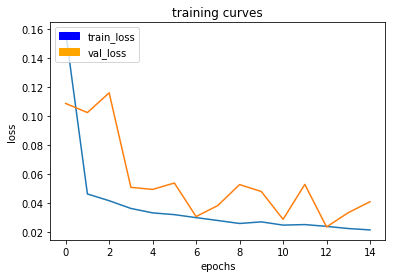

128/128 [==============================] - 76s - loss: 0.0216 - val_loss: 0.0410
Epoch 16/100
127/128 [============================>.] - ETA: 0s - loss: 0.0207

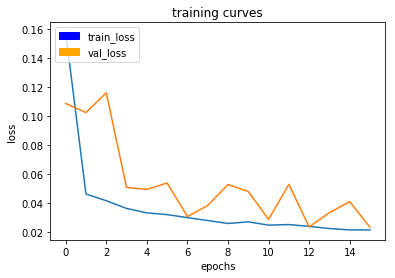

128/128 [==============================] - 76s - loss: 0.0216 - val_loss: 0.0234
Epoch 17/100
127/128 [============================>.] - ETA: 0s - loss: 0.0229

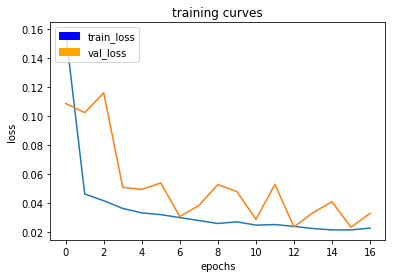

128/128 [==============================] - 76s - loss: 0.0229 - val_loss: 0.0330
Epoch 18/100
127/128 [============================>.] - ETA: 0s - loss: 0.0202

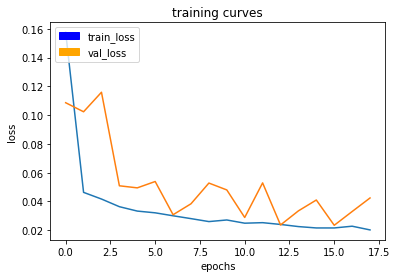

128/128 [==============================] - 76s - loss: 0.0202 - val_loss: 0.0424
Epoch 19/100
127/128 [============================>.] - ETA: 0s - loss: 0.0205

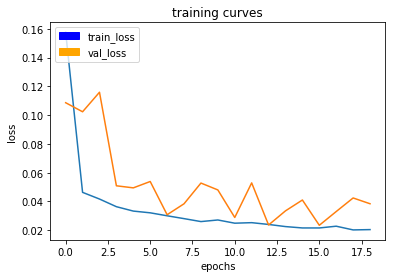

128/128 [==============================] - 76s - loss: 0.0204 - val_loss: 0.0384
Epoch 20/100
127/128 [============================>.] - ETA: 0s - loss: 0.0205

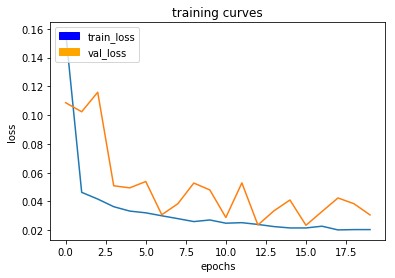

128/128 [==============================] - 76s - loss: 0.0205 - val_loss: 0.0306
Epoch 21/100
127/128 [============================>.] - ETA: 0s - loss: 0.0196

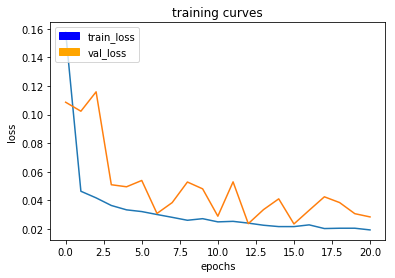

128/128 [==============================] - 76s - loss: 0.0196 - val_loss: 0.0284
Epoch 22/100
127/128 [============================>.] - ETA: 0s - loss: 0.0198

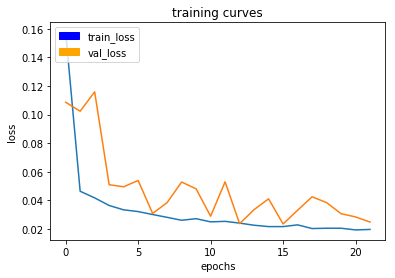

128/128 [==============================] - 76s - loss: 0.0198 - val_loss: 0.0248
Epoch 23/100
127/128 [============================>.] - ETA: 0s - loss: 0.0187

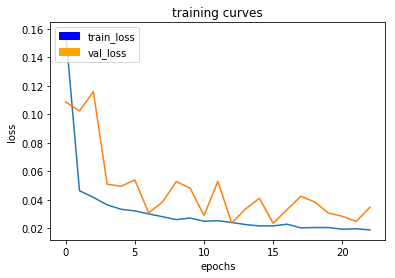

128/128 [==============================] - 76s - loss: 0.0187 - val_loss: 0.0348
Epoch 24/100
127/128 [============================>.] - ETA: 0s - loss: 0.0169

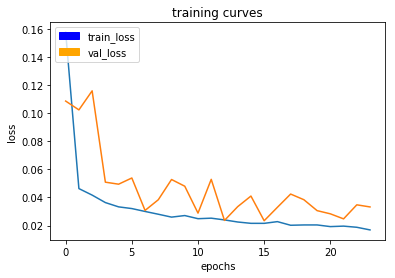

128/128 [==============================] - 76s - loss: 0.0169 - val_loss: 0.0332
Epoch 25/100
127/128 [============================>.] - ETA: 0s - loss: 0.0197

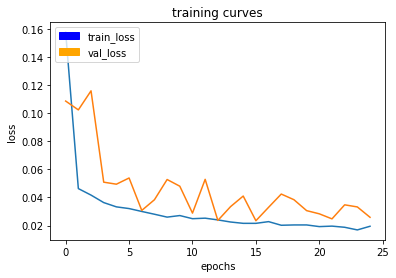

128/128 [==============================] - 76s - loss: 0.0198 - val_loss: 0.0259
Epoch 26/100
127/128 [============================>.] - ETA: 0s - loss: 0.0169

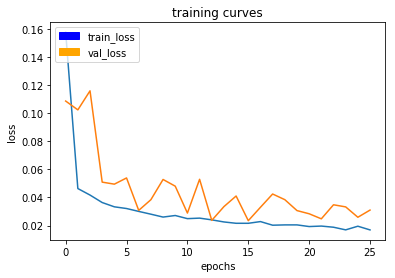

128/128 [==============================] - 75s - loss: 0.0168 - val_loss: 0.0310
Epoch 27/100
127/128 [============================>.] - ETA: 0s - loss: 0.0182

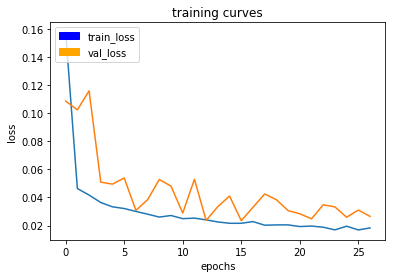

128/128 [==============================] - 76s - loss: 0.0182 - val_loss: 0.0265
Epoch 28/100
127/128 [============================>.] - ETA: 0s - loss: 0.0177

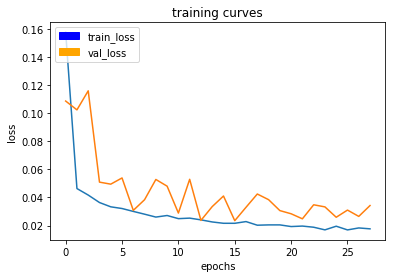

128/128 [==============================] - 75s - loss: 0.0177 - val_loss: 0.0342
Epoch 29/100
127/128 [============================>.] - ETA: 0s - loss: 0.0171

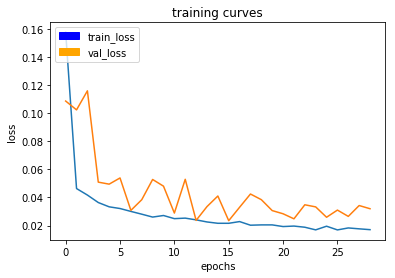

128/128 [==============================] - 75s - loss: 0.0171 - val_loss: 0.0319
Epoch 30/100
127/128 [============================>.] - ETA: 0s - loss: 0.0157

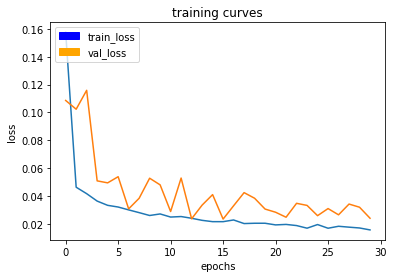

128/128 [==============================] - 76s - loss: 0.0156 - val_loss: 0.0240
Epoch 31/100
127/128 [============================>.] - ETA: 0s - loss: 0.0161

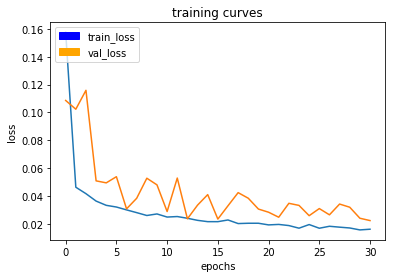

128/128 [==============================] - 76s - loss: 0.0161 - val_loss: 0.0224
Epoch 32/100
127/128 [============================>.] - ETA: 0s - loss: 0.0166

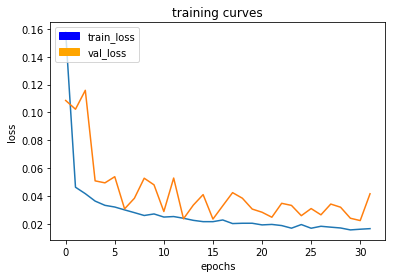

128/128 [==============================] - 76s - loss: 0.0166 - val_loss: 0.0416
Epoch 33/100
127/128 [============================>.] - ETA: 0s - loss: 0.0163

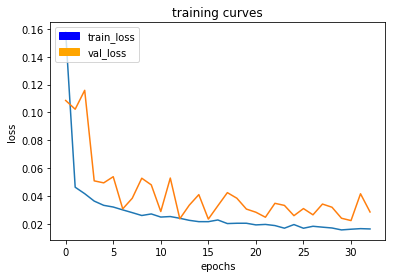

128/128 [==============================] - 76s - loss: 0.0163 - val_loss: 0.0285
Epoch 34/100
127/128 [============================>.] - ETA: 0s - loss: 0.0158

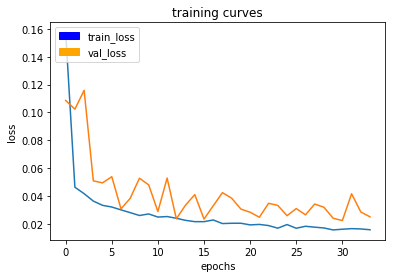

128/128 [==============================] - 76s - loss: 0.0158 - val_loss: 0.0250
Epoch 35/100
127/128 [============================>.] - ETA: 0s - loss: 0.0164

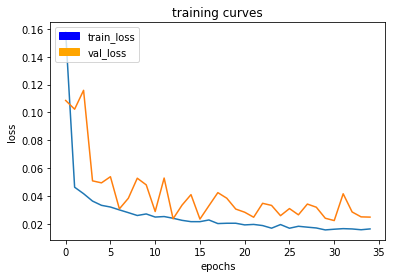

128/128 [==============================] - 76s - loss: 0.0164 - val_loss: 0.0248
Epoch 36/100
127/128 [============================>.] - ETA: 0s - loss: 0.0157

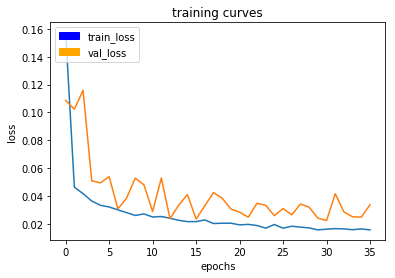

128/128 [==============================] - 76s - loss: 0.0156 - val_loss: 0.0337
Epoch 37/100
127/128 [============================>.] - ETA: 0s - loss: 0.0150

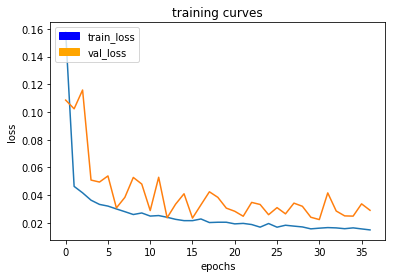

128/128 [==============================] - 75s - loss: 0.0150 - val_loss: 0.0290
Epoch 38/100
127/128 [============================>.] - ETA: 0s - loss: 0.0141

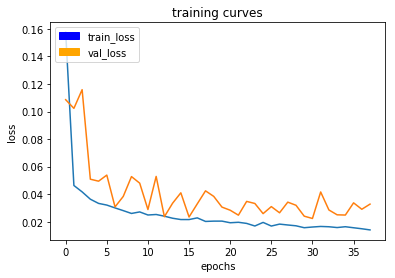

128/128 [==============================] - 76s - loss: 0.0141 - val_loss: 0.0328
Epoch 39/100
127/128 [============================>.] - ETA: 0s - loss: 0.0130

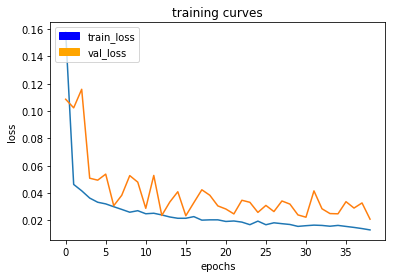

128/128 [==============================] - 76s - loss: 0.0130 - val_loss: 0.0209
Epoch 40/100
127/128 [============================>.] - ETA: 0s - loss: 0.0134

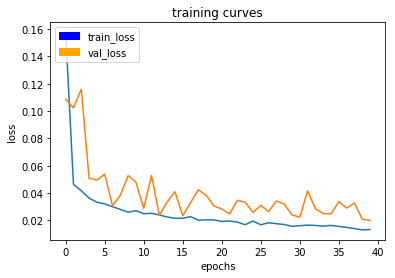

128/128 [==============================] - 76s - loss: 0.0134 - val_loss: 0.0200
Epoch 41/100
127/128 [============================>.] - ETA: 0s - loss: 0.0142

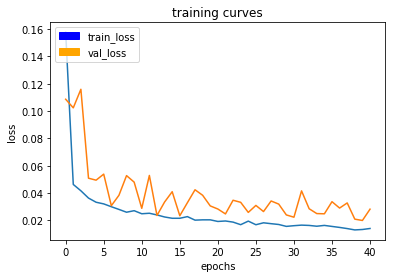

128/128 [==============================] - 76s - loss: 0.0142 - val_loss: 0.0282
Epoch 42/100
127/128 [============================>.] - ETA: 0s - loss: 0.0132

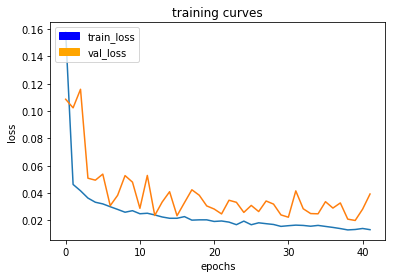

128/128 [==============================] - 76s - loss: 0.0132 - val_loss: 0.0393
Epoch 43/100
127/128 [============================>.] - ETA: 0s - loss: 0.0142

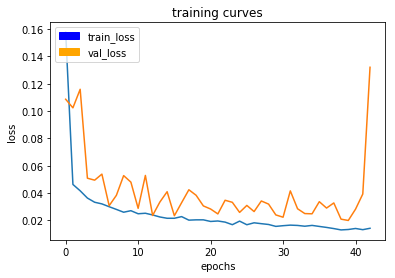

128/128 [==============================] - 76s - loss: 0.0143 - val_loss: 0.1320
Epoch 44/100
127/128 [============================>.] - ETA: 0s - loss: 0.0187

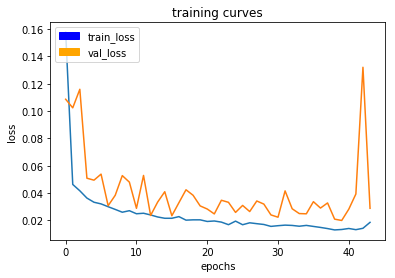

128/128 [==============================] - 76s - loss: 0.0187 - val_loss: 0.0289
Epoch 45/100
127/128 [============================>.] - ETA: 0s - loss: 0.0165

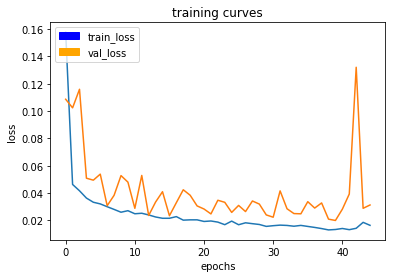

128/128 [==============================] - 76s - loss: 0.0165 - val_loss: 0.0313
Epoch 46/100
127/128 [============================>.] - ETA: 0s - loss: 0.0148

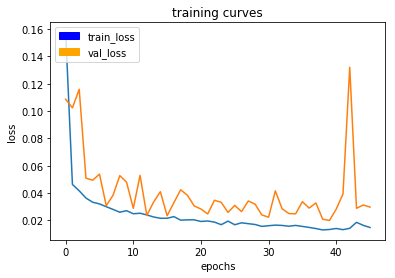

128/128 [==============================] - 76s - loss: 0.0148 - val_loss: 0.0297
Epoch 47/100
127/128 [============================>.] - ETA: 0s - loss: 0.0139

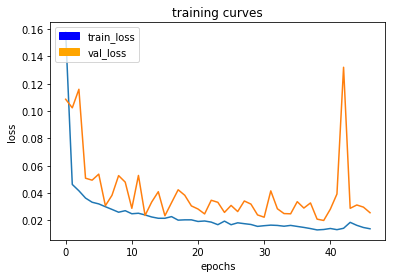

128/128 [==============================] - 76s - loss: 0.0139 - val_loss: 0.0256
Epoch 48/100
127/128 [============================>.] - ETA: 0s - loss: 0.0133

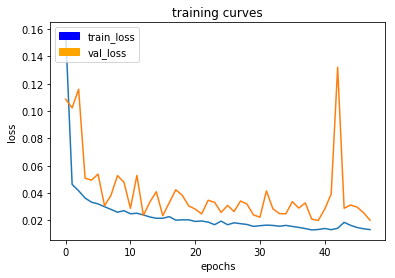

128/128 [==============================] - 76s - loss: 0.0133 - val_loss: 0.0202
Epoch 49/100
127/128 [============================>.] - ETA: 0s - loss: 0.0121

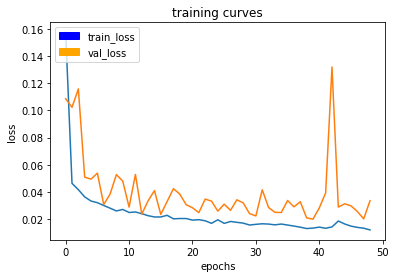

128/128 [==============================] - 76s - loss: 0.0121 - val_loss: 0.0335
Epoch 50/100
127/128 [============================>.] - ETA: 0s - loss: 0.0151

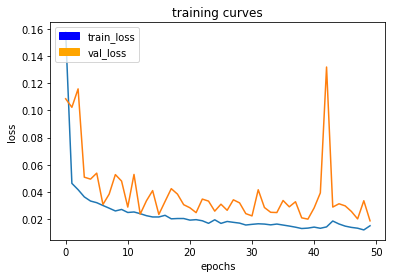

128/128 [==============================] - 76s - loss: 0.0151 - val_loss: 0.0187
Epoch 51/100
127/128 [============================>.] - ETA: 0s - loss: 0.0131

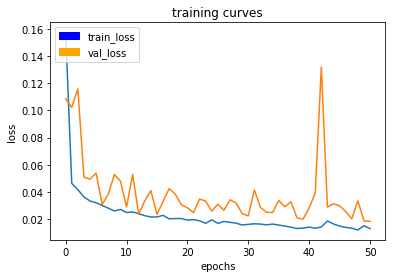

128/128 [==============================] - 76s - loss: 0.0131 - val_loss: 0.0183
Epoch 52/100
127/128 [============================>.] - ETA: 0s - loss: 0.0124

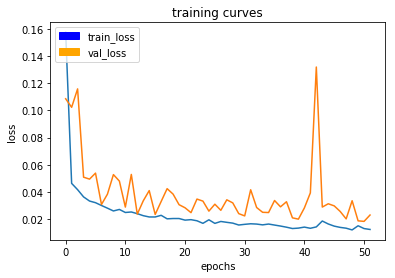

128/128 [==============================] - 76s - loss: 0.0124 - val_loss: 0.0230
Epoch 53/100
127/128 [============================>.] - ETA: 0s - loss: 0.0122

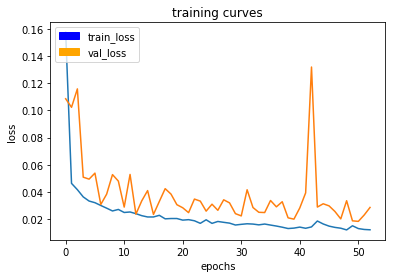

128/128 [==============================] - 76s - loss: 0.0122 - val_loss: 0.0286
Epoch 54/100
127/128 [============================>.] - ETA: 0s - loss: 0.0124

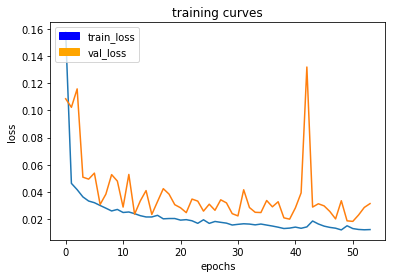

128/128 [==============================] - 76s - loss: 0.0124 - val_loss: 0.0314
Epoch 55/100
127/128 [============================>.] - ETA: 0s - loss: 0.0152

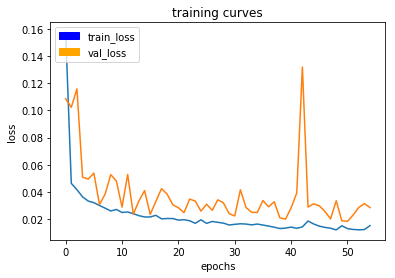

128/128 [==============================] - 76s - loss: 0.0152 - val_loss: 0.0285
Epoch 56/100
127/128 [============================>.] - ETA: 0s - loss: 0.0131

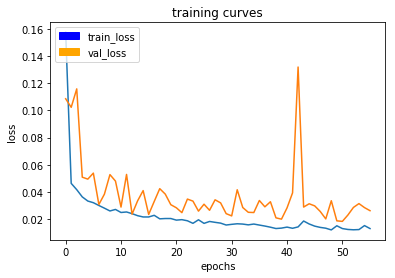

128/128 [==============================] - 76s - loss: 0.0130 - val_loss: 0.0262
Epoch 57/100
127/128 [============================>.] - ETA: 0s - loss: 0.0130

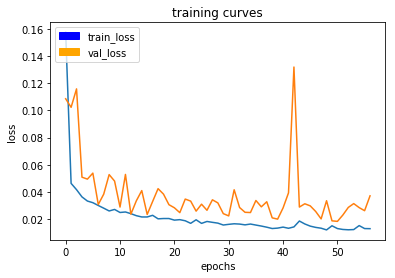

128/128 [==============================] - 76s - loss: 0.0130 - val_loss: 0.0371
Epoch 58/100
127/128 [============================>.] - ETA: 0s - loss: 0.0136

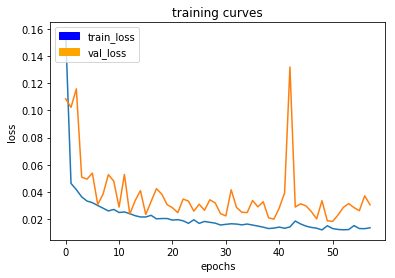

128/128 [==============================] - 76s - loss: 0.0136 - val_loss: 0.0305
Epoch 59/100
127/128 [============================>.] - ETA: 0s - loss: 0.0118

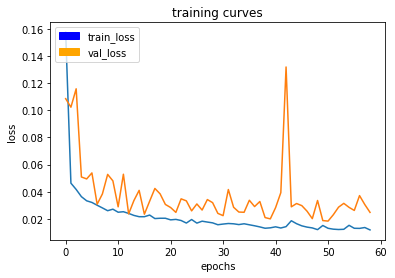

128/128 [==============================] - 76s - loss: 0.0118 - val_loss: 0.0248
Epoch 60/100
127/128 [============================>.] - ETA: 0s - loss: 0.0112

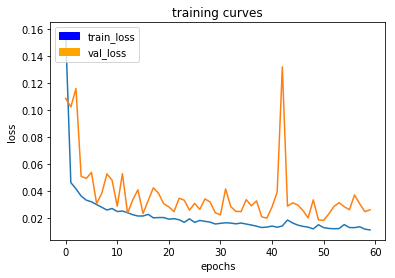

128/128 [==============================] - 76s - loss: 0.0113 - val_loss: 0.0262
Epoch 61/100
127/128 [============================>.] - ETA: 0s - loss: 0.0116

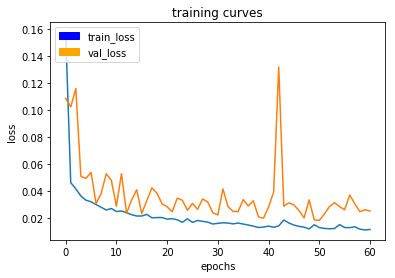

128/128 [==============================] - 76s - loss: 0.0116 - val_loss: 0.0253
Epoch 62/100
127/128 [============================>.] - ETA: 0s - loss: 0.0110

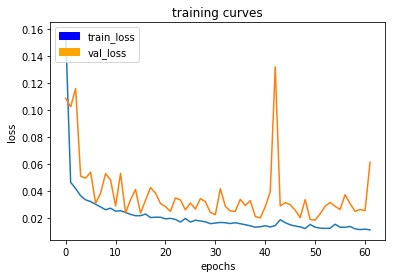

128/128 [==============================] - 76s - loss: 0.0110 - val_loss: 0.0612
Epoch 63/100
127/128 [============================>.] - ETA: 0s - loss: 0.0119

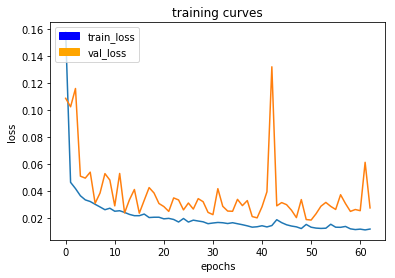

128/128 [==============================] - 76s - loss: 0.0119 - val_loss: 0.0273
Epoch 64/100
127/128 [============================>.] - ETA: 0s - loss: 0.0151

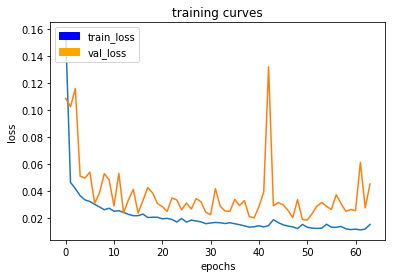

128/128 [==============================] - 76s - loss: 0.0151 - val_loss: 0.0451
Epoch 65/100
127/128 [============================>.] - ETA: 0s - loss: 0.0137

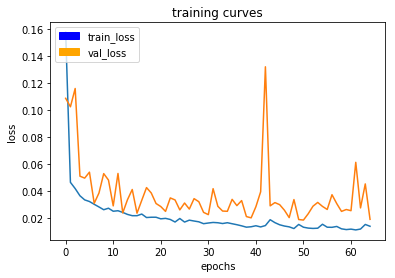

128/128 [==============================] - 76s - loss: 0.0137 - val_loss: 0.0189
Epoch 66/100
127/128 [============================>.] - ETA: 0s - loss: 0.0120

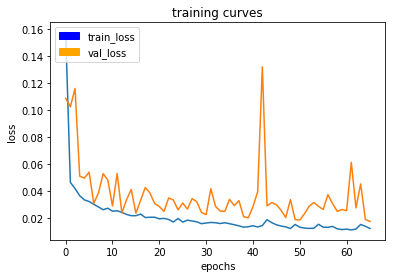

128/128 [==============================] - 76s - loss: 0.0120 - val_loss: 0.0173
Epoch 67/100
127/128 [============================>.] - ETA: 0s - loss: 0.0111

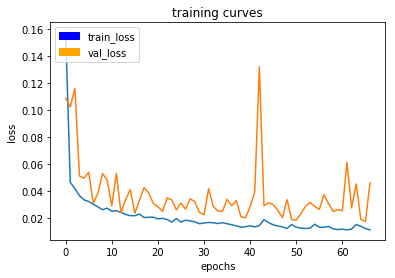

128/128 [==============================] - 76s - loss: 0.0111 - val_loss: 0.0459
Epoch 68/100
127/128 [============================>.] - ETA: 0s - loss: 0.0114

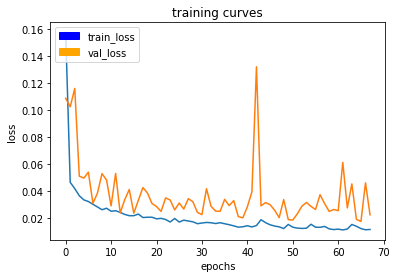

128/128 [==============================] - 76s - loss: 0.0114 - val_loss: 0.0222
Epoch 69/100
127/128 [============================>.] - ETA: 0s - loss: 0.0105

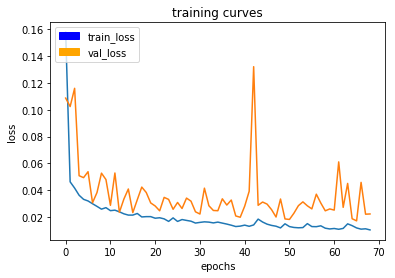

128/128 [==============================] - 76s - loss: 0.0105 - val_loss: 0.0224
Epoch 70/100
127/128 [============================>.] - ETA: 0s - loss: 0.0129

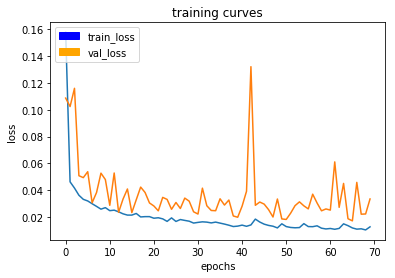

128/128 [==============================] - 76s - loss: 0.0129 - val_loss: 0.0336
Epoch 71/100
127/128 [============================>.] - ETA: 0s - loss: 0.0167

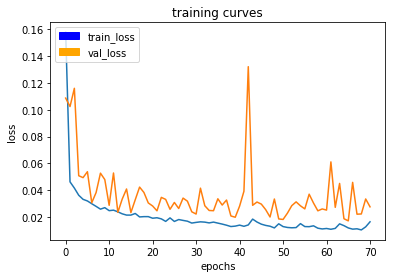

128/128 [==============================] - 76s - loss: 0.0167 - val_loss: 0.0277
Epoch 72/100
127/128 [============================>.] - ETA: 0s - loss: 0.0132

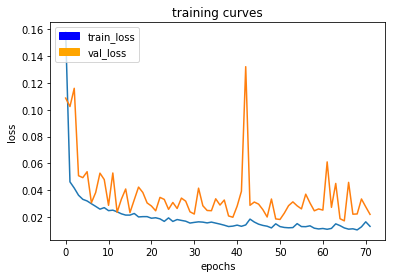

128/128 [==============================] - 76s - loss: 0.0132 - val_loss: 0.0221
Epoch 73/100
127/128 [============================>.] - ETA: 0s - loss: 0.0123

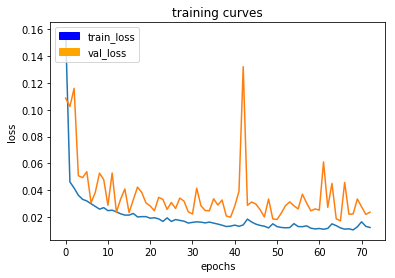

128/128 [==============================] - 76s - loss: 0.0123 - val_loss: 0.0238
Epoch 74/100
127/128 [============================>.] - ETA: 0s - loss: 0.0109

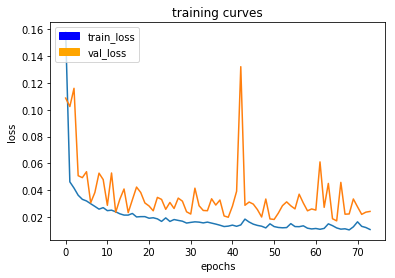

128/128 [==============================] - 76s - loss: 0.0109 - val_loss: 0.0243
Epoch 75/100
127/128 [============================>.] - ETA: 0s - loss: 0.0157

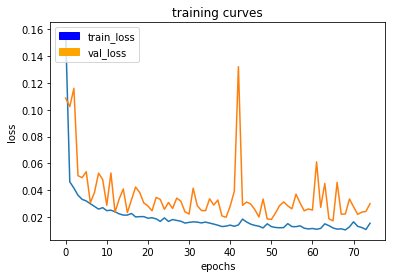

128/128 [==============================] - 76s - loss: 0.0158 - val_loss: 0.0301
Epoch 76/100
127/128 [============================>.] - ETA: 0s - loss: 0.0127

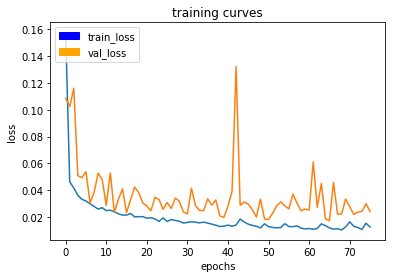

128/128 [==============================] - 76s - loss: 0.0127 - val_loss: 0.0243
Epoch 77/100
127/128 [============================>.] - ETA: 0s - loss: 0.0123

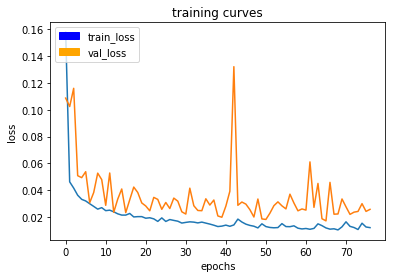

128/128 [==============================] - 75s - loss: 0.0123 - val_loss: 0.0259
Epoch 78/100
127/128 [============================>.] - ETA: 0s - loss: 0.0110

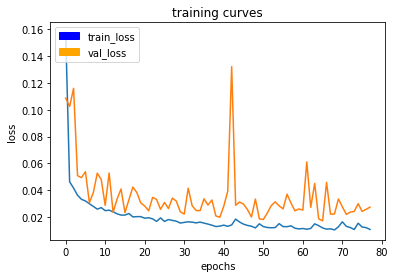

128/128 [==============================] - 76s - loss: 0.0110 - val_loss: 0.0275
Epoch 79/100
127/128 [============================>.] - ETA: 0s - loss: 0.0104

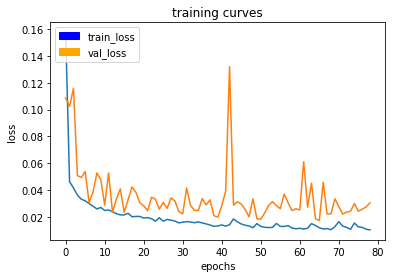

128/128 [==============================] - 76s - loss: 0.0104 - val_loss: 0.0306
Epoch 80/100
127/128 [============================>.] - ETA: 0s - loss: 0.0105

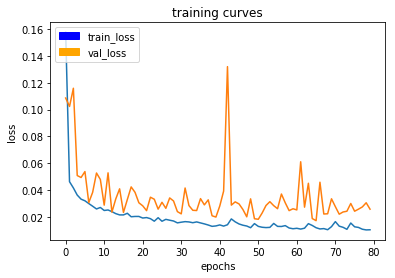

128/128 [==============================] - 76s - loss: 0.0105 - val_loss: 0.0258
Epoch 81/100
127/128 [============================>.] - ETA: 0s - loss: 0.0098

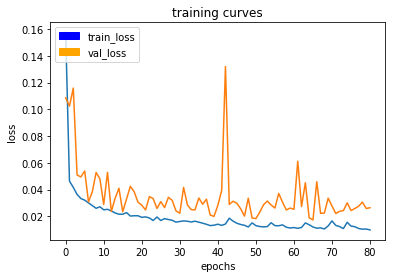

128/128 [==============================] - 76s - loss: 0.0098 - val_loss: 0.0264
Epoch 82/100
127/128 [============================>.] - ETA: 0s - loss: 0.0128

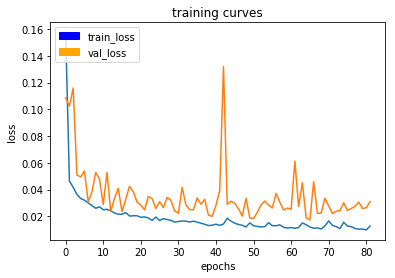

128/128 [==============================] - 76s - loss: 0.0128 - val_loss: 0.0310
Epoch 83/100
127/128 [============================>.] - ETA: 0s - loss: 0.0114

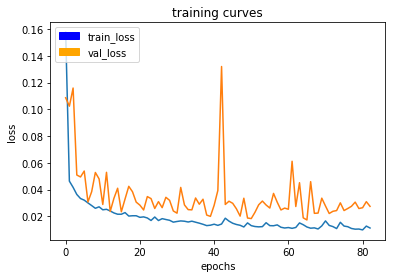

128/128 [==============================] - 76s - loss: 0.0113 - val_loss: 0.0275
Epoch 84/100
127/128 [============================>.] - ETA: 0s - loss: 0.0108

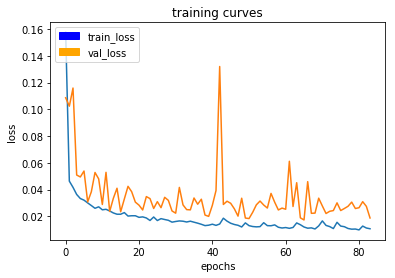

128/128 [==============================] - 76s - loss: 0.0108 - val_loss: 0.0188
Epoch 85/100
127/128 [============================>.] - ETA: 0s - loss: 0.0107

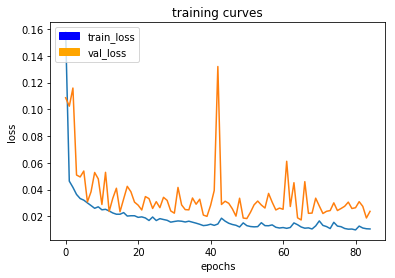

128/128 [==============================] - 75s - loss: 0.0107 - val_loss: 0.0237
Epoch 86/100
127/128 [============================>.] - ETA: 0s - loss: 0.0239

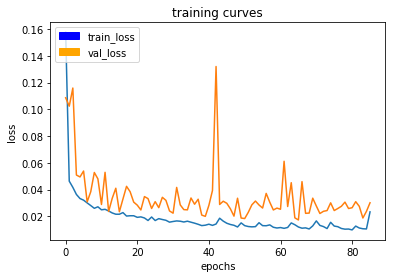

128/128 [==============================] - 76s - loss: 0.0238 - val_loss: 0.0301
Epoch 87/100
127/128 [============================>.] - ETA: 0s - loss: 0.0135

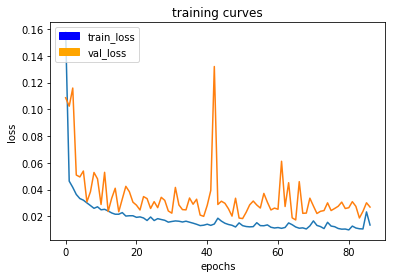

128/128 [==============================] - 76s - loss: 0.0135 - val_loss: 0.0269
Epoch 88/100
127/128 [============================>.] - ETA: 0s - loss: 0.0129

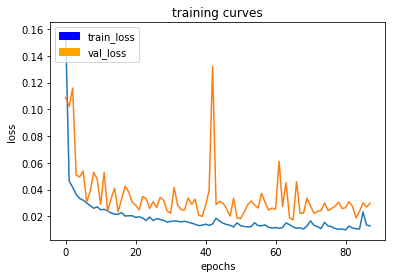

128/128 [==============================] - 76s - loss: 0.0129 - val_loss: 0.0296
Epoch 89/100
127/128 [============================>.] - ETA: 0s - loss: 0.0118

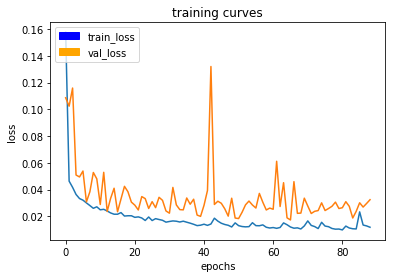

128/128 [==============================] - 76s - loss: 0.0118 - val_loss: 0.0324
Epoch 90/100
127/128 [============================>.] - ETA: 0s - loss: 0.0106

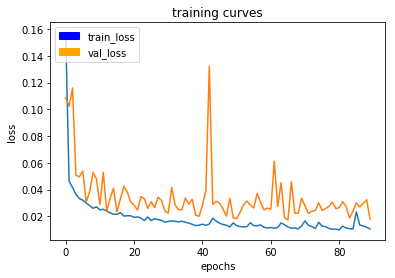

128/128 [==============================] - 76s - loss: 0.0106 - val_loss: 0.0178
Epoch 91/100
127/128 [============================>.] - ETA: 0s - loss: 0.0103

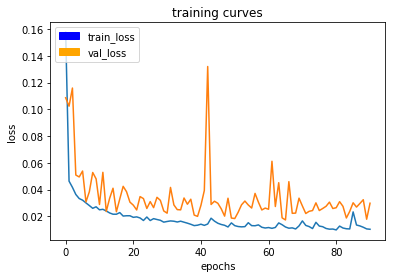

128/128 [==============================] - 76s - loss: 0.0103 - val_loss: 0.0298
Epoch 92/100
127/128 [============================>.] - ETA: 0s - loss: 0.0104

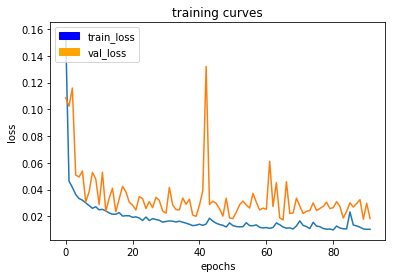

128/128 [==============================] - 76s - loss: 0.0104 - val_loss: 0.0184
Epoch 93/100
127/128 [============================>.] - ETA: 0s - loss: 0.0099

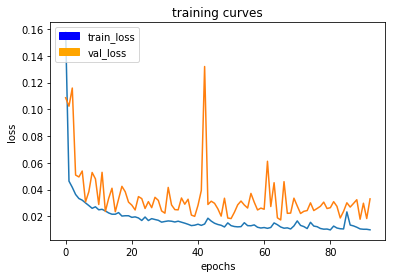

128/128 [==============================] - 76s - loss: 0.0099 - val_loss: 0.0330
Epoch 94/100
127/128 [============================>.] - ETA: 0s - loss: 0.0100

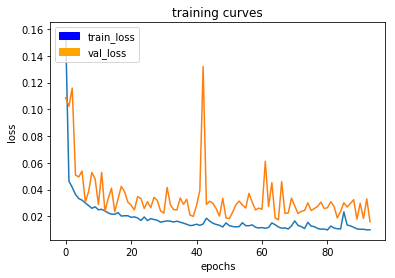

128/128 [==============================] - 76s - loss: 0.0100 - val_loss: 0.0159
Epoch 95/100
127/128 [============================>.] - ETA: 0s - loss: 0.0101

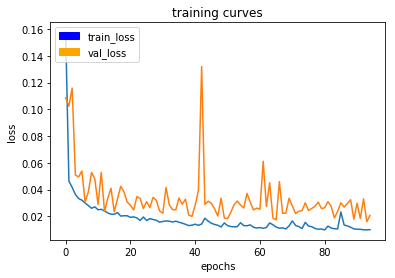

128/128 [==============================] - 76s - loss: 0.0101 - val_loss: 0.0207
Epoch 96/100
127/128 [============================>.] - ETA: 0s - loss: 0.0095

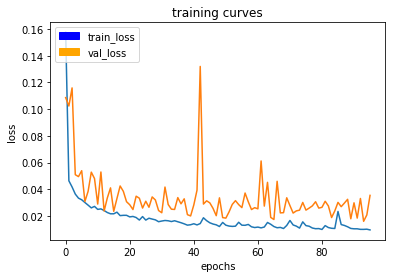

128/128 [==============================] - 76s - loss: 0.0095 - val_loss: 0.0354
Epoch 97/100
127/128 [============================>.] - ETA: 0s - loss: 0.0099

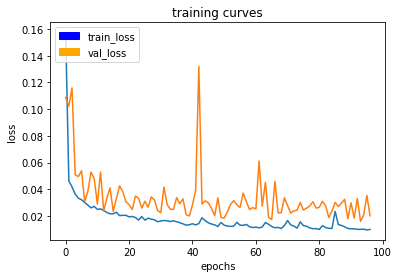

128/128 [==============================] - 76s - loss: 0.0099 - val_loss: 0.0201
Epoch 98/100
127/128 [============================>.] - ETA: 0s - loss: 0.0099

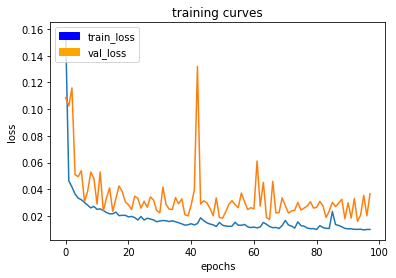

128/128 [==============================] - 76s - loss: 0.0099 - val_loss: 0.0366
Epoch 99/100
127/128 [============================>.] - ETA: 0s - loss: 0.0128

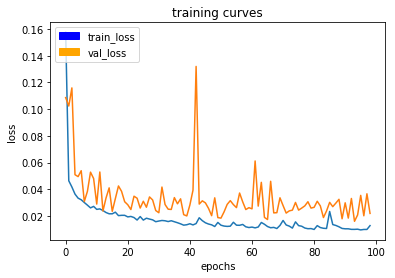

128/128 [==============================] - 76s - loss: 0.0127 - val_loss: 0.0219
Epoch 100/100
127/128 [============================>.] - ETA: 0s - loss: 0.0113

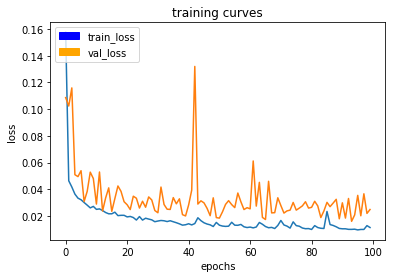

128/128 [==============================] - 76s - loss: 0.0113 - val_loss: 0.0248


In [43]:
# RUN FOUR

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.01
batch_size = 32
num_epochs = 100
steps_per_epoch = int(4131/batch_size)-1
validation_steps = int(1184/batch_size)-1
workers = 2 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights_4.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [44]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights_4.h5'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [45]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

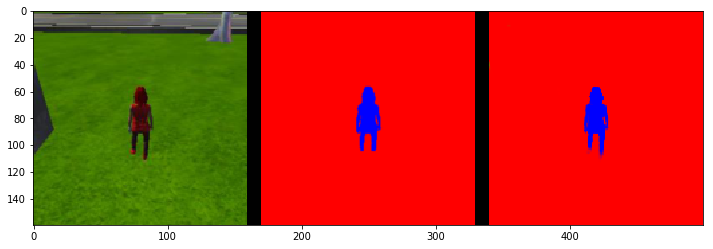

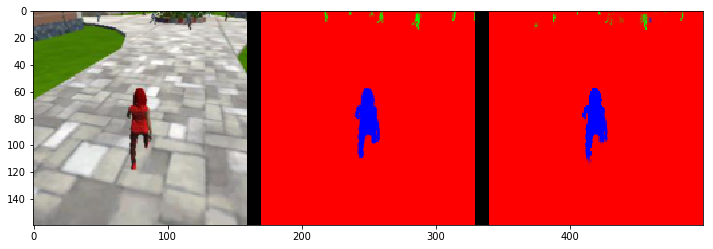

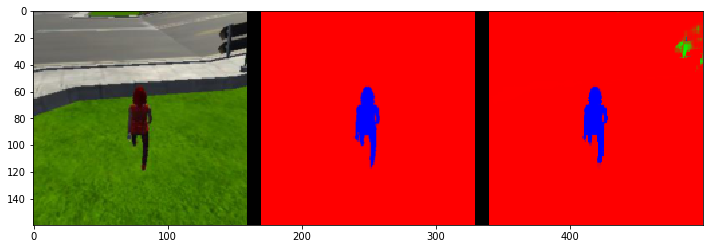

In [46]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

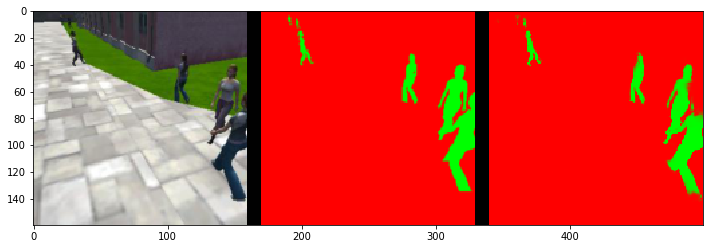

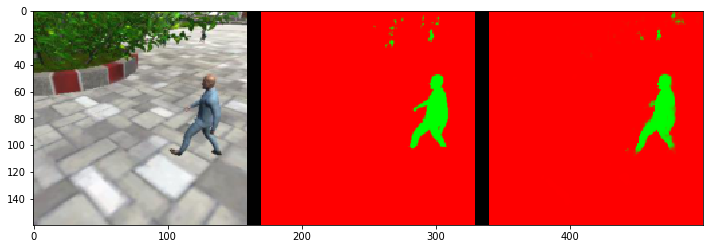

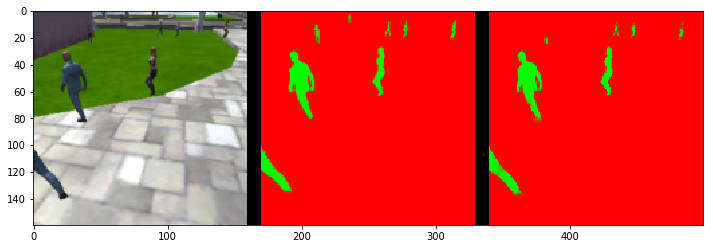

In [47]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

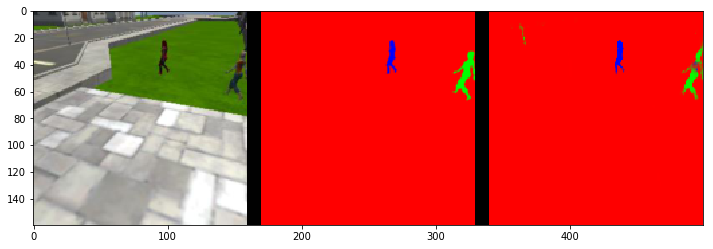

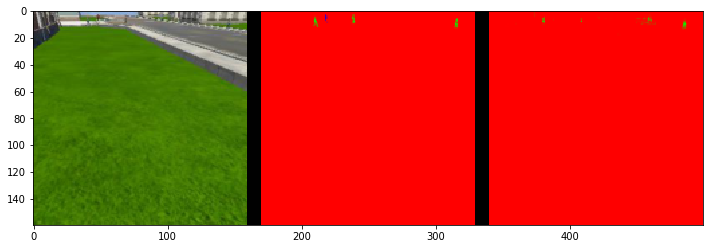

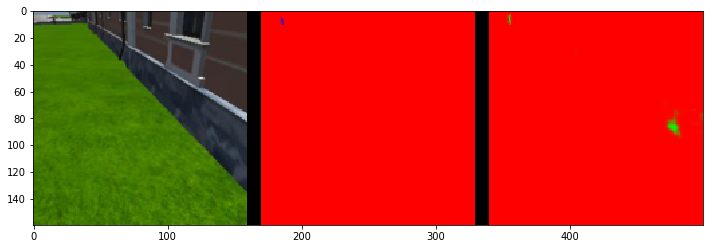

In [48]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [49]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9961742971668668
average intersection over union for other people is 0.39427018145250897
average intersection over union for the hero is 0.920458414091173
number true positives: 539, number false positives: 0, number false negatives: 0


In [50]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9880586863430326
average intersection over union for other people is 0.7585536694443019
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 46, number false negatives: 0


In [51]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9968963110170872
average intersection over union for other people is 0.4878551244807152
average intersection over union for the hero is 0.24286792192738424
number true positives: 137, number false positives: 2, number false negatives: 164


In [52]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7612612612612613


In [53]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.581663168009


In [54]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.442797636908


## Final IoU Score = 0.442797636908!!!